In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import struct
import collections
import pathlib

In [2]:
CE5_AOSInsertZone = Struct(
    'unknown1' / Hex(Int8ub),
    'unknown2' / Int8ub,
    'unknown3' / Hex(Int8ub),
    'unknown4' / Hex(Int8ub),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSInsertZone,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes
)

def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f"Chang'e 5 Spacecraft ID {sc} APID {apid} Virtual channel {vc}")

def get_packet_timestamps(packets):
    return np.datetime64('2012-08-01') + np.timedelta64(1,'s')*np.array([p[1] for p in packets])

Here we look at some Chang'e 5 low data rate telemetry received with Allen Telescope array on 2020-11-28 before LOI-1, the lunar orbit insertion burn. The recorded data corresponds to the frequency 8463.7 MHz, which corresponds to the lander.

The frames are CCSDS concatenated frames with a frames size of 220 bytes.

In [3]:
def load_frames(path):
    frame_size = 220
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    return frames

In [4]:
frames = load_frames('ATA_2020-12-13/ce5_frames_1.u8')

## AOS frames

AOS frames come from spacecraft 91 and virtual channels 1 and 2. Other combinations are most likely to corruted frames despite the fact that the Reed-Solomon decoder was successful.

In [5]:
aos = [CE5_AOSFrame.parse(f) for f in frames]

In [6]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 11206})

In [7]:
collections.Counter([a.primary_header.spacecraft_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({108: 11133, 35: 71, 236: 1, 175: 1})

In [8]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({1: 11133, 45: 71, 15: 2})

## Virtual channel 1

The vast majority of frames belong to virtual channel 1, which seems to send real-time telemetry.

In [9]:
[a.primary_header for a in aos if a.primary_header.virtual_channel_id == 1][:10]

[Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=1322520, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=1322521, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=1322522, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=1322523, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=1322524, replay_flag=False, vc_frame_co

In [10]:
vc1 = [a for a in aos if a.primary_header.virtual_channel_id == 1]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc1])
[a.insert_zone for a in aos[:10]]

[Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097768),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097769),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097770),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097771),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097772),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097773),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097774),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097775),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097776),
 Container(unknown1=199, unknown2=25, unknown3=93, unknown4=3, timestamp=264097777)]

In [11]:
t_vc1 = np.datetime64('2012-08-01') + np.timedelta64(1, 's') * np.array([a.insert_zone.timestamp for a in vc1])

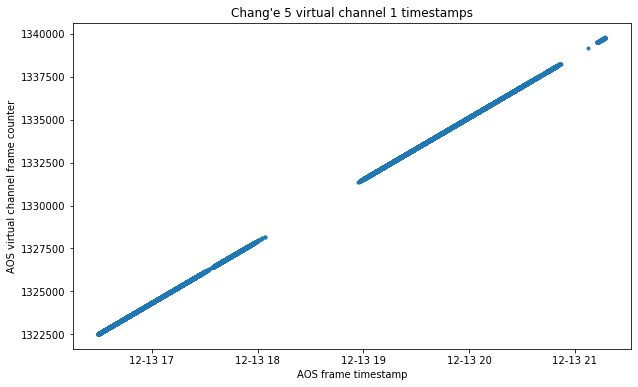

In [12]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t_vc1, fc, '.')
plt.title("Chang'e 5 virtual channel 1 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

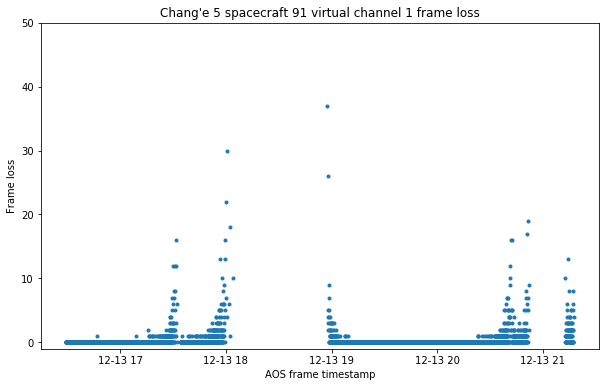

In [13]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t_vc1[1:], np.diff(fc)-1, '.')
plt.title("Chang'e 5 spacecraft 91 virtual channel 1 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Frame loss')
plt.ylim((-1,50));

We need to sort the data, since the different files we've loaded up are not in chronological order.

In [14]:
vc1_packets = list(ccsds.extract_space_packets(vc1, 108, 1, get_timestamps = True))

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1323547, current frame count 1323549
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1324880, current frame count 1324882
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1325290, current frame count 1325293
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1325976, current frame count 1325978
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1325983, current frame count 1325985
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1325992, current frame count 1325994
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1326159, current frame count 1326166
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1326166, current frame count 1326170
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1326170, current frame count 1326173
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327002, current frame count 1327004
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327066, current frame count 1327068
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327069, current frame count 1327071
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327541, current frame count 1327543
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327544, current frame count 1327546
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327547, current frame count 1327550
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327692, current frame count 1327696
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327696, current frame count 1327698
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1327700, current frame count 1327702
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1331482, current frame count 1331484
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1331486, current frame count 1331490
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1331490, current frame count 1331494
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1331625, current frame count 1331629
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1331632, current frame count 1331634
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1331638, current frame count 1331640
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337065, current frame count 1337067
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337102, current frame count 1337104
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337118, current frame count 1337120
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337350, current frame count 1337352
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337358, current frame count 1337360
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337361, current frame count 1337363
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337477, current frame count 1337479
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337479, current frame count 1337481
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337482, current frame count 1337485
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337746, current frame count 1337748
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337748, current frame count 1337753
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337755, current frame count 1337757
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337952, current frame count 1337955
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337964, current frame count 1337966
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1337967, current frame count 1337969
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1339548, current frame count 1339555
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1339556, current frame count 1339559
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1339560, current frame count 1339562
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1339757, current frame count 1339763
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1339763, current frame count 1339766
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 1339766, current frame count 1339769
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: 

In [15]:
vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in vc1_packets]

There are space packets in may APIDs. The contents of each APID are shown belown in plot form, but it's not easy to guess what any of the values mean.

In [16]:
vc1_apids = collections.Counter([p.APID for p in vc1_sp_headers])
vc1_apids

Counter({40: 11133,
         1030: 5555,
         5: 2090,
         28: 1990,
         33: 1954,
         41: 3699,
         281: 3598,
         11: 1156,
         34: 1121,
         48: 586,
         49: 1893,
         282: 1086,
         52: 3633,
         42: 2274,
         13: 2049,
         14: 2026,
         43: 2377,
         258: 581,
         39: 1106,
         51: 1092,
         1040: 1873,
         259: 1087,
         30: 602,
         283: 310,
         285: 298,
         27: 1149,
         29: 1131,
         4: 605,
         31: 589,
         50: 308,
         58: 153,
         35: 595,
         7: 601,
         6: 153,
         2: 307,
         1031: 310,
         1032: 305,
         1034: 305,
         1039: 301,
         286: 296,
         257: 307,
         260: 300,
         16: 150,
         3: 310,
         261: 300,
         278: 306,
         296: 303,
         25: 155,
         26: 153,
         12: 78,
         60: 155,
         1029: 155})

In [17]:
vc1_by_apid = {apid : [p for h,p in zip(vc1_sp_headers, vc1_packets)
                           if h.APID == apid] for apid in vc1_apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


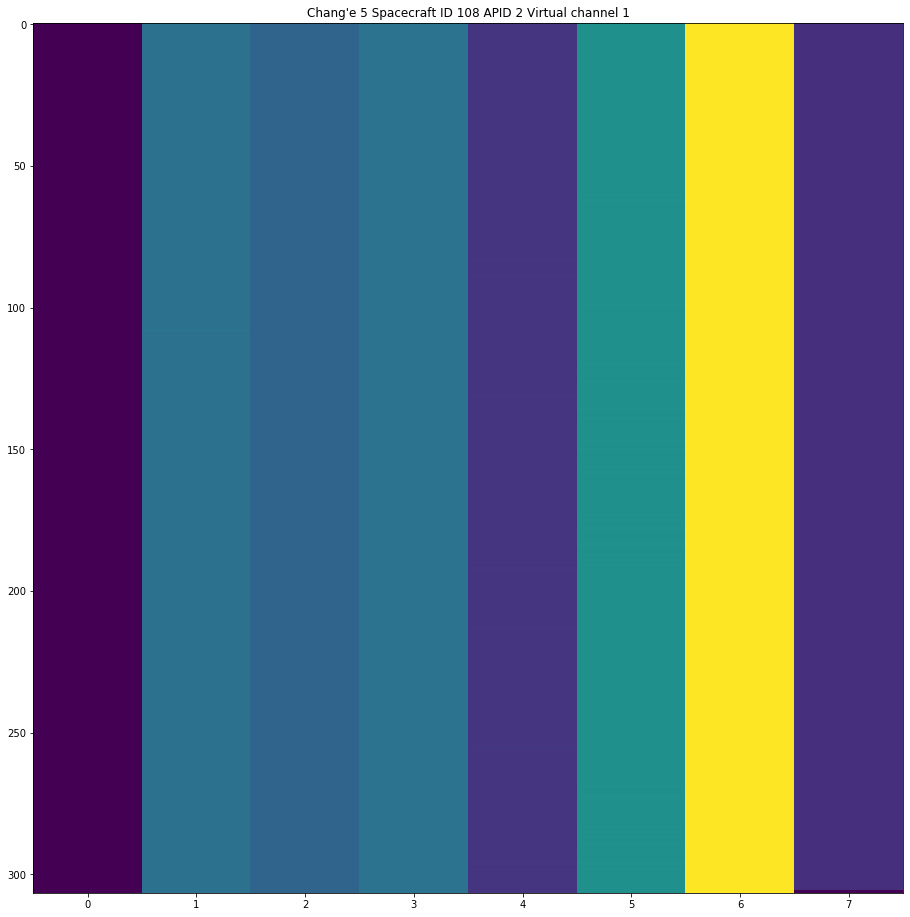

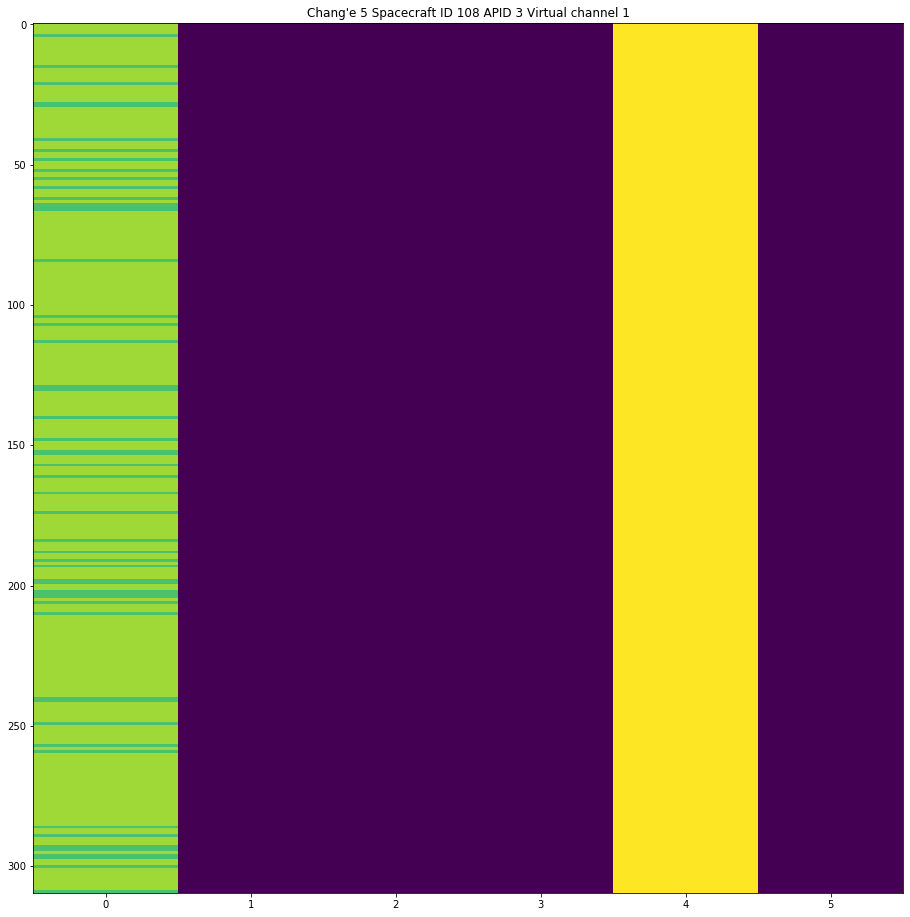

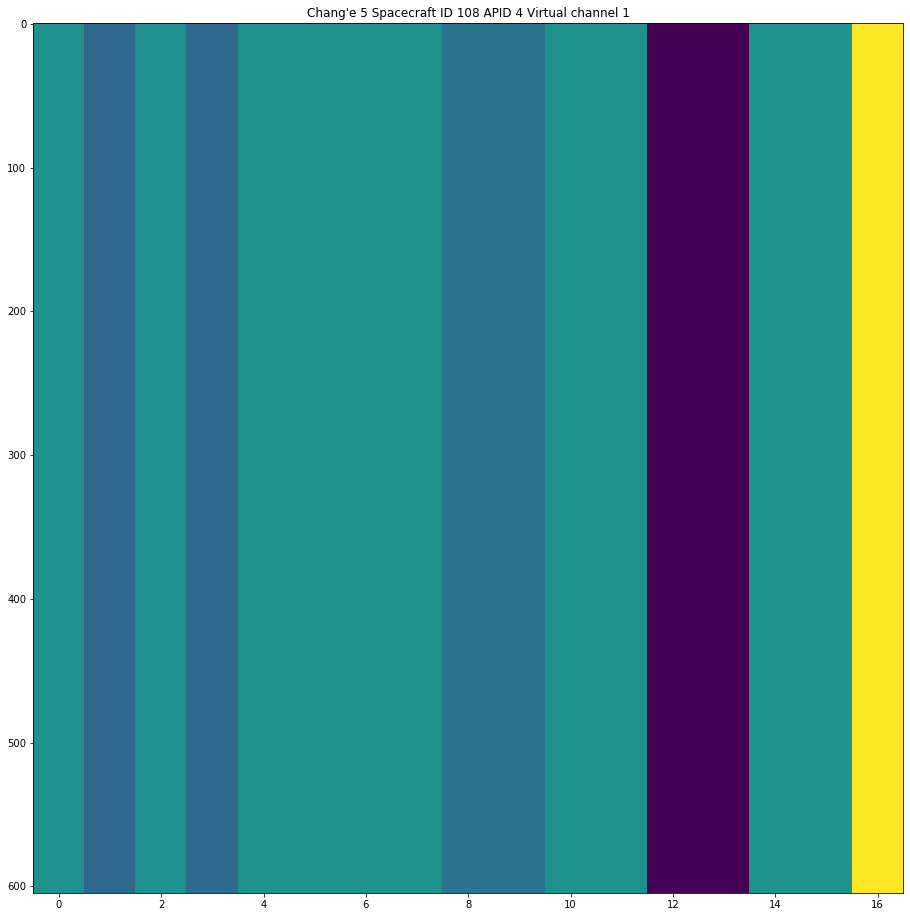

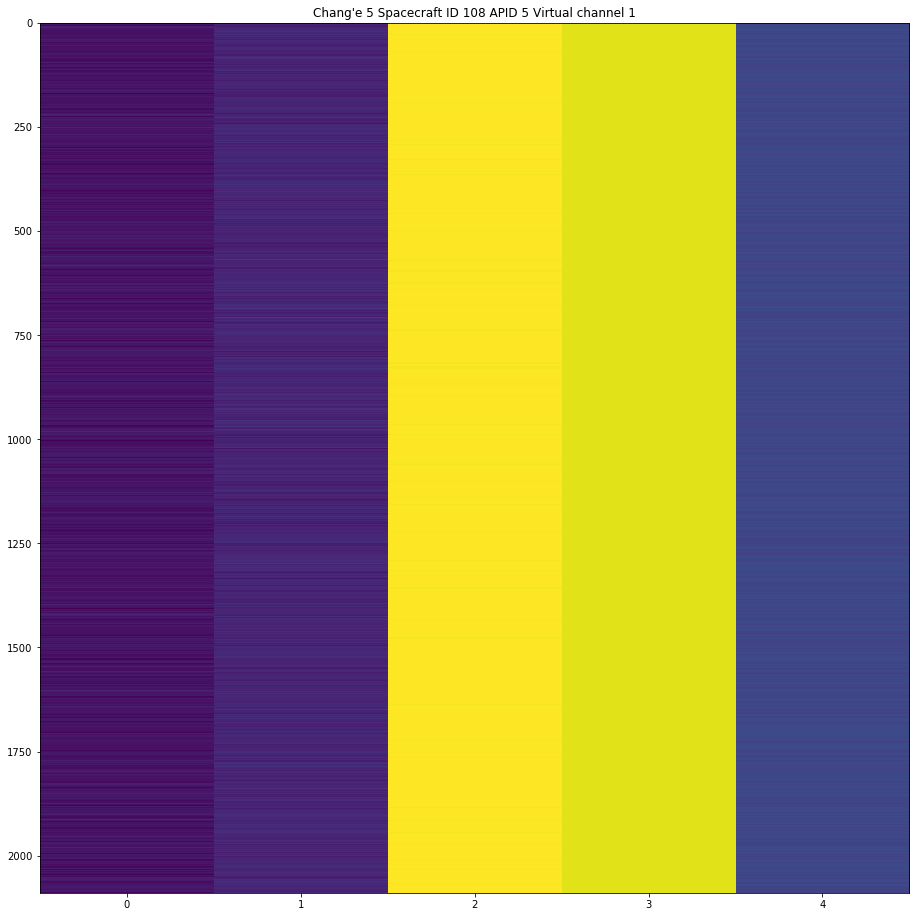

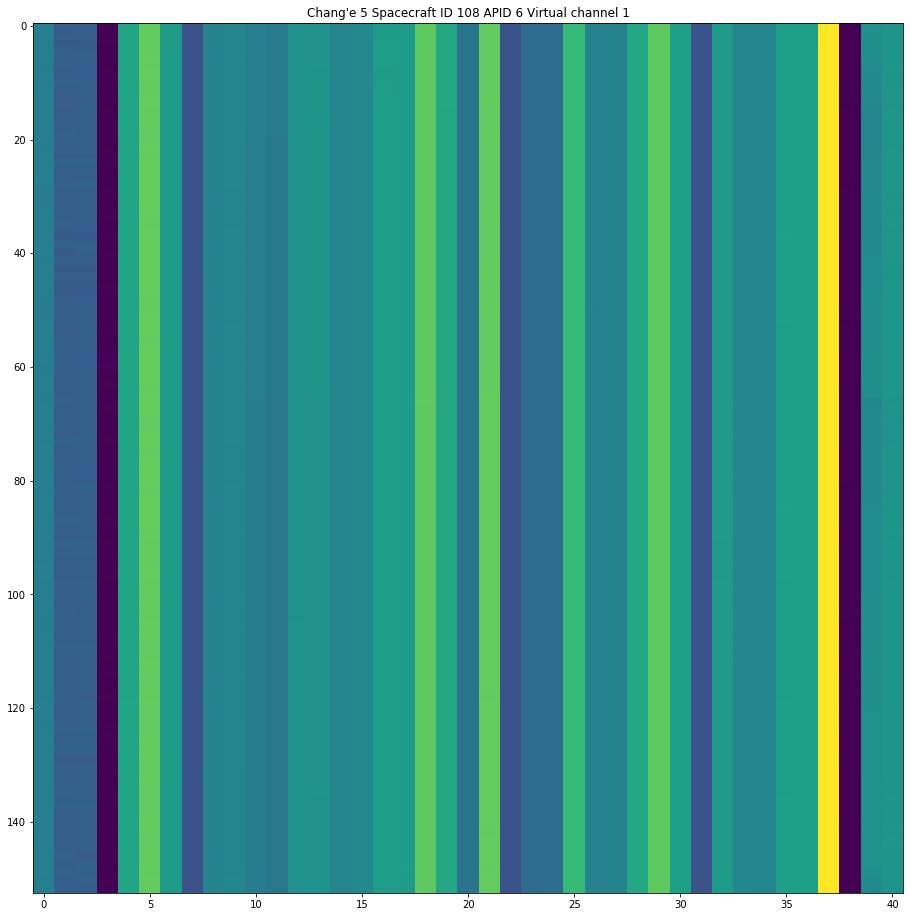

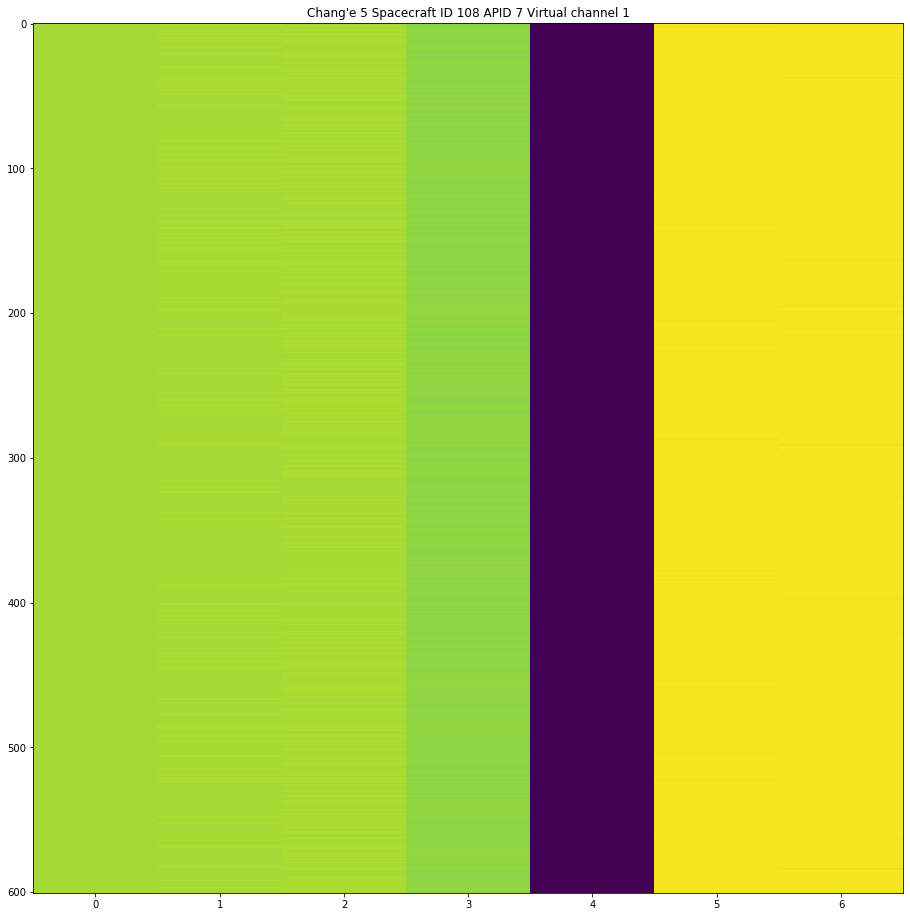

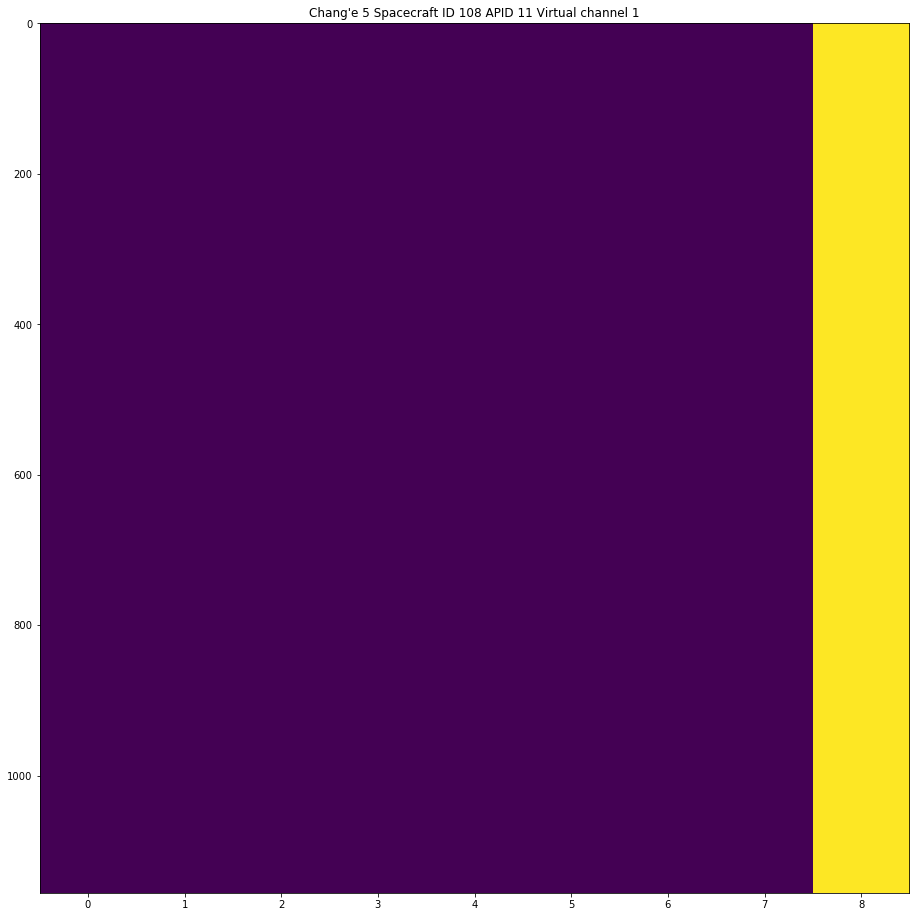

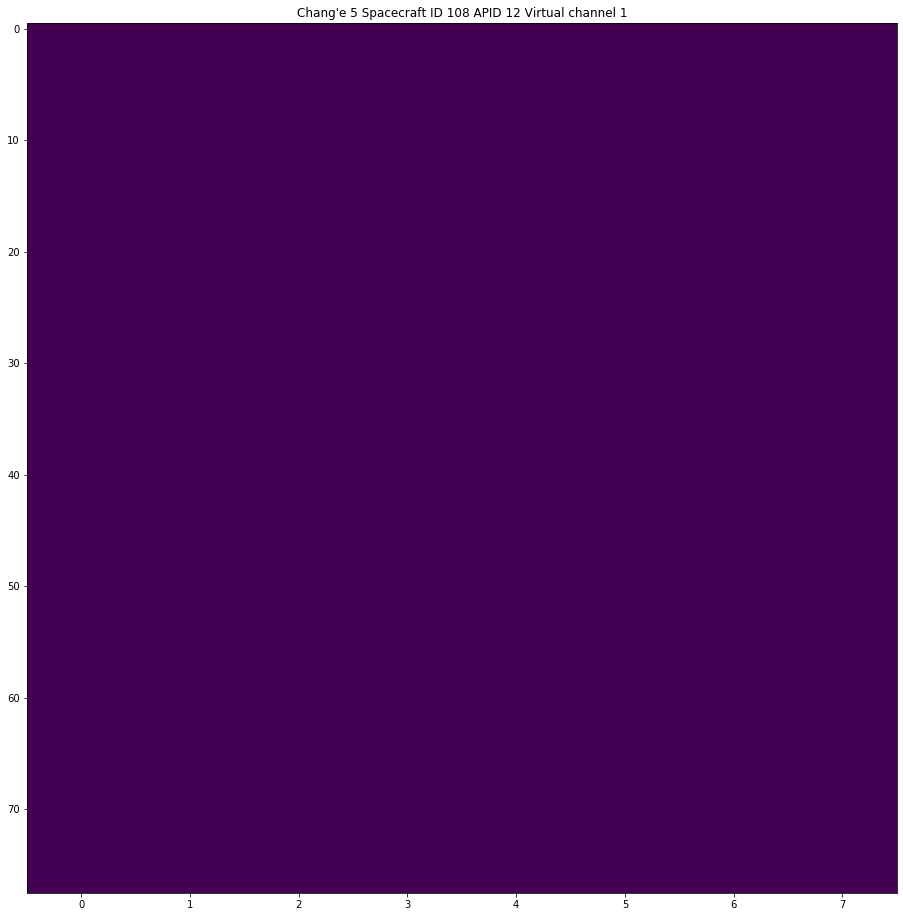

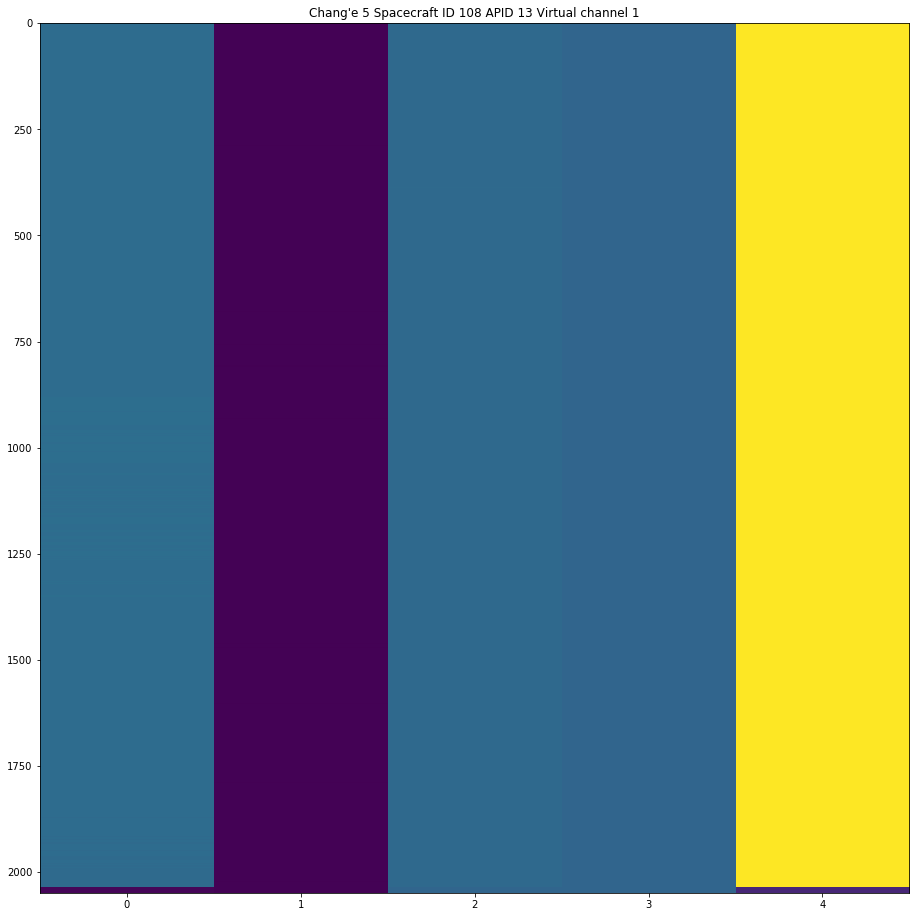

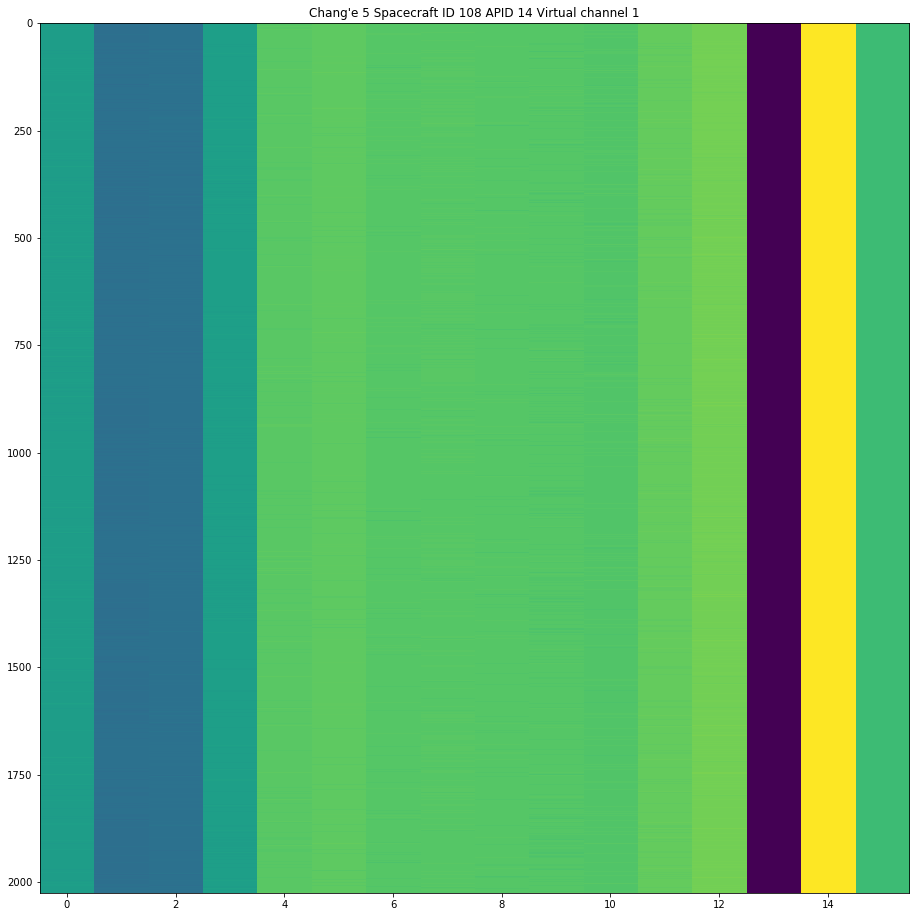

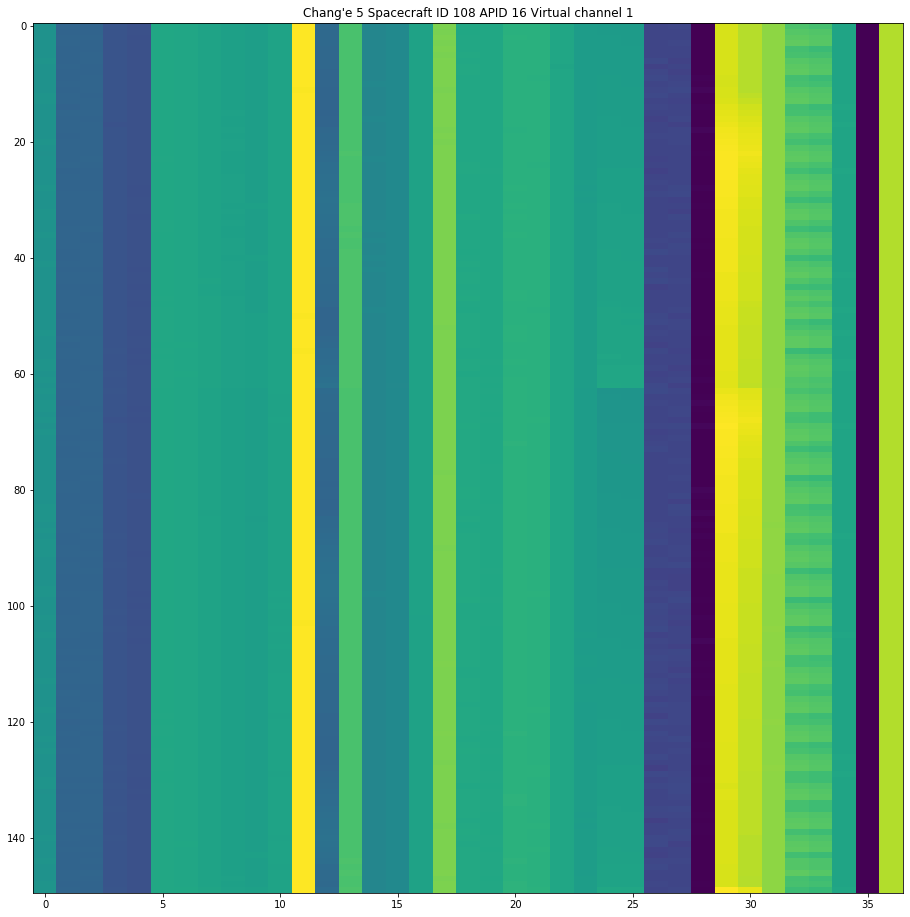

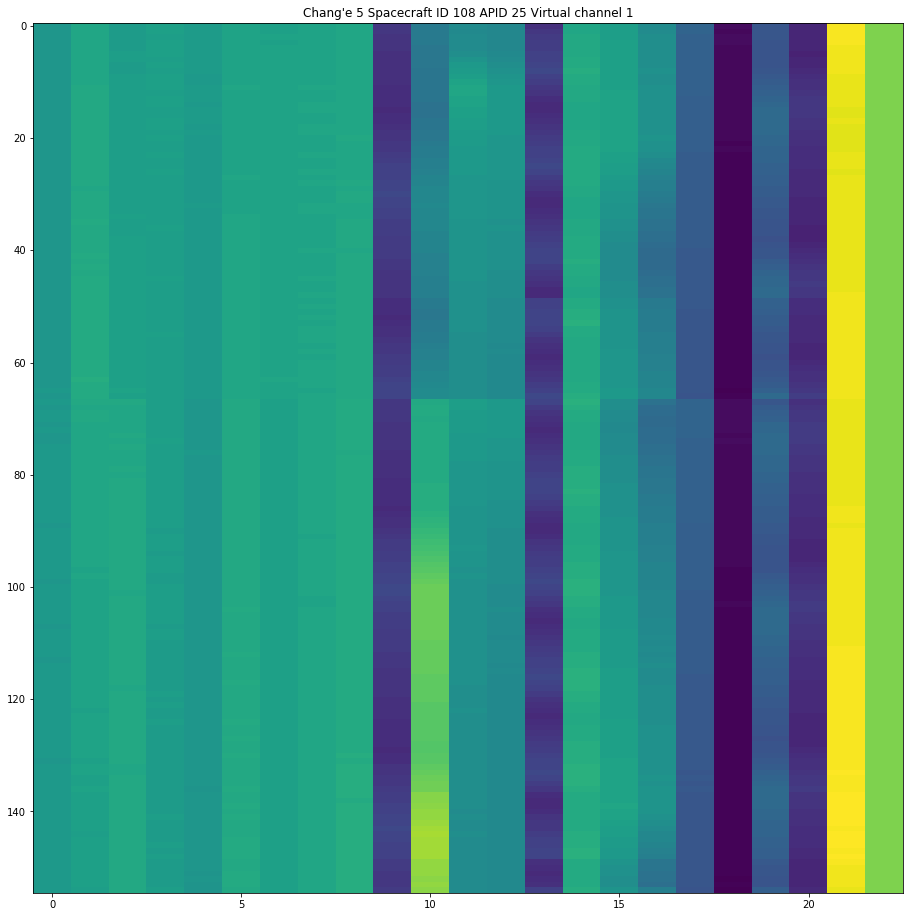

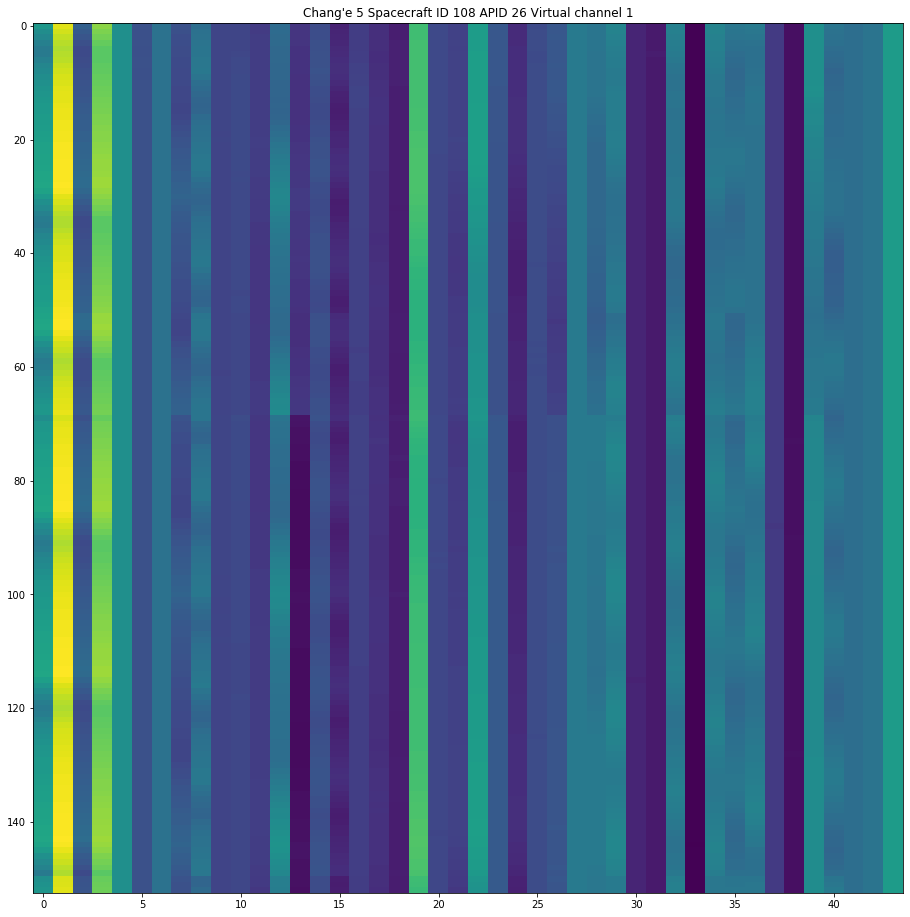

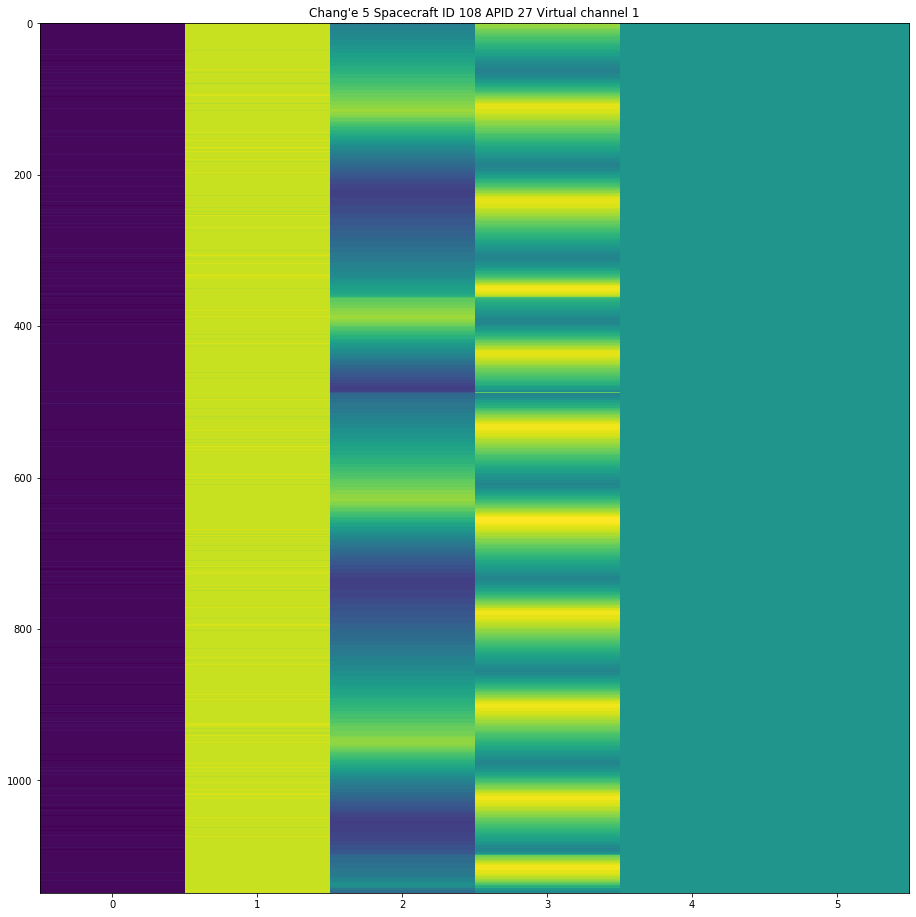

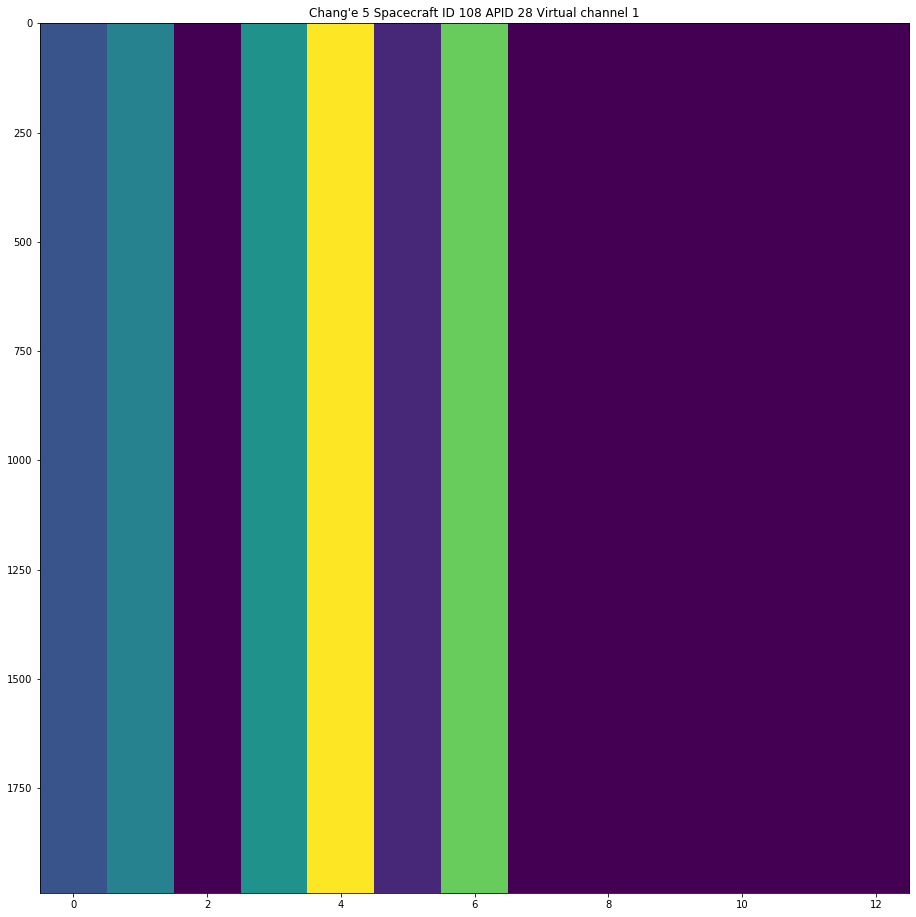

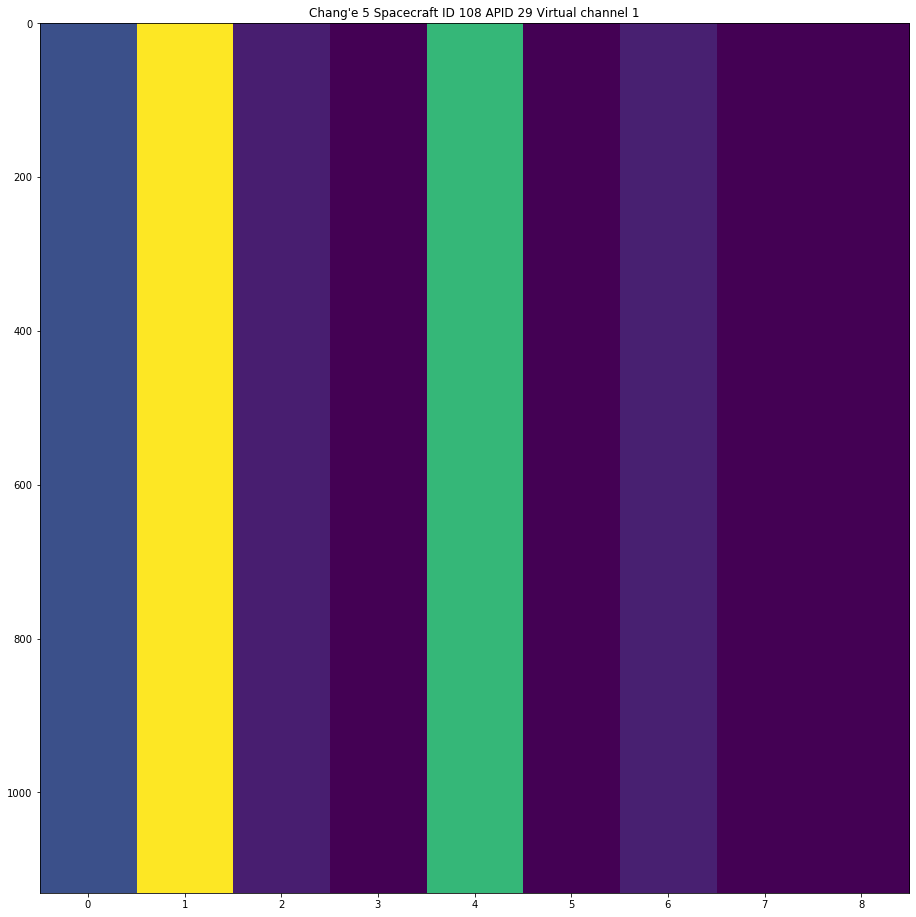

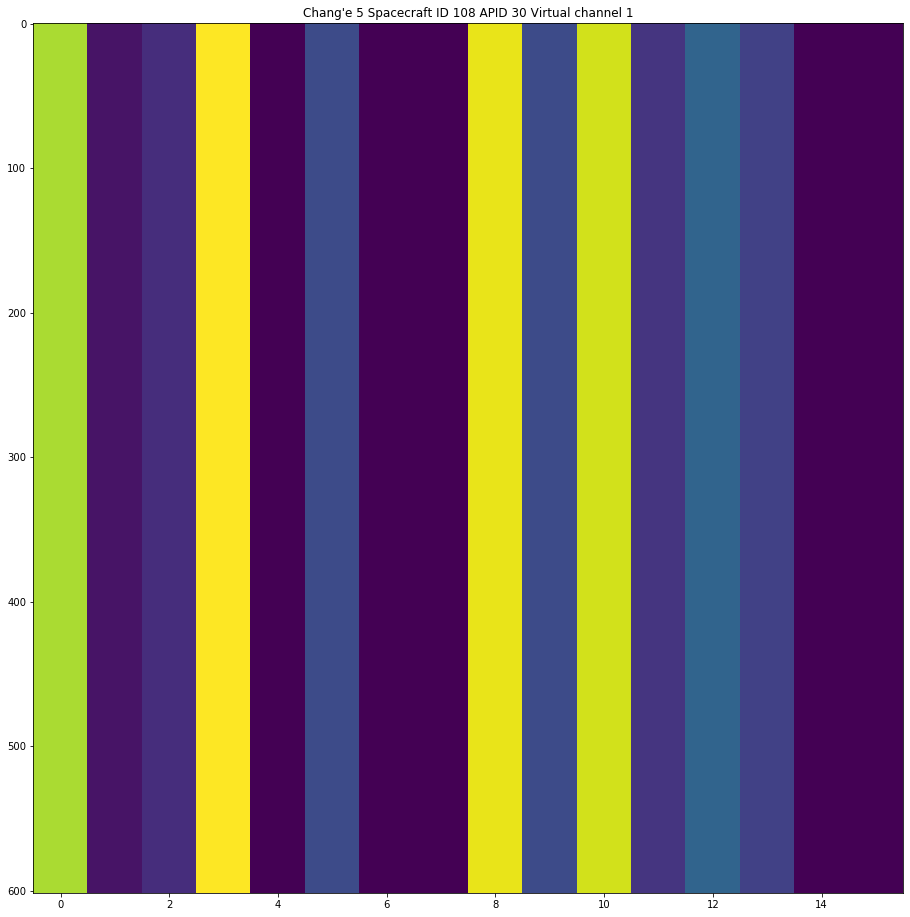

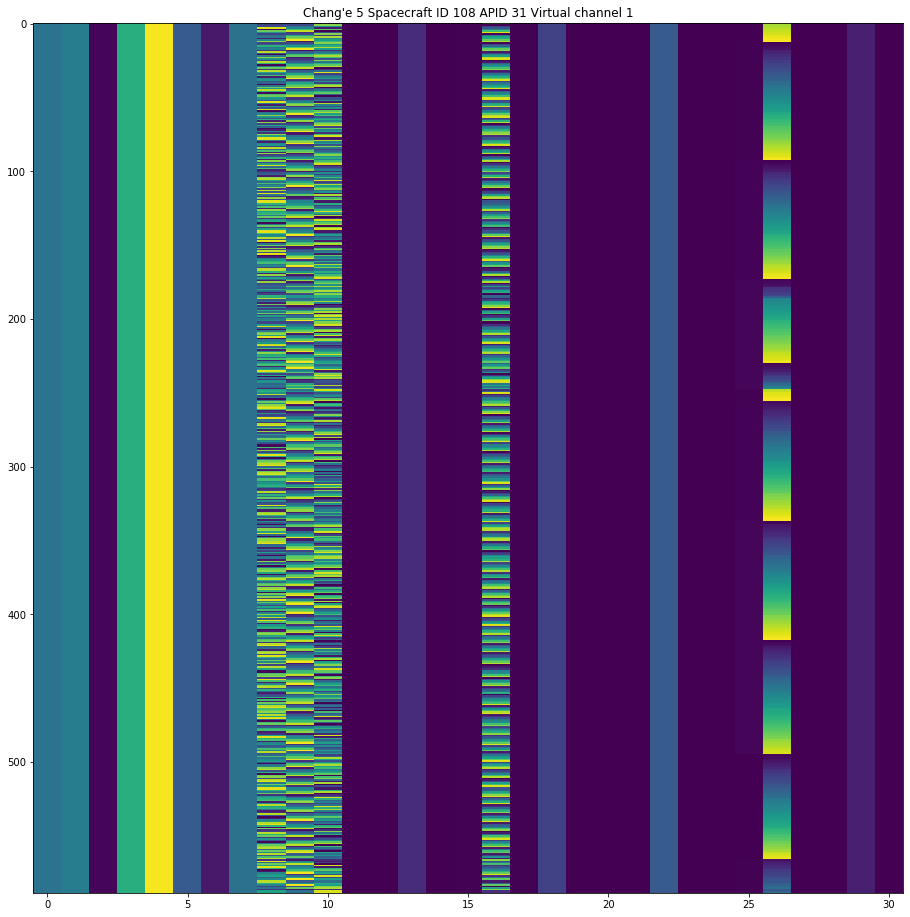

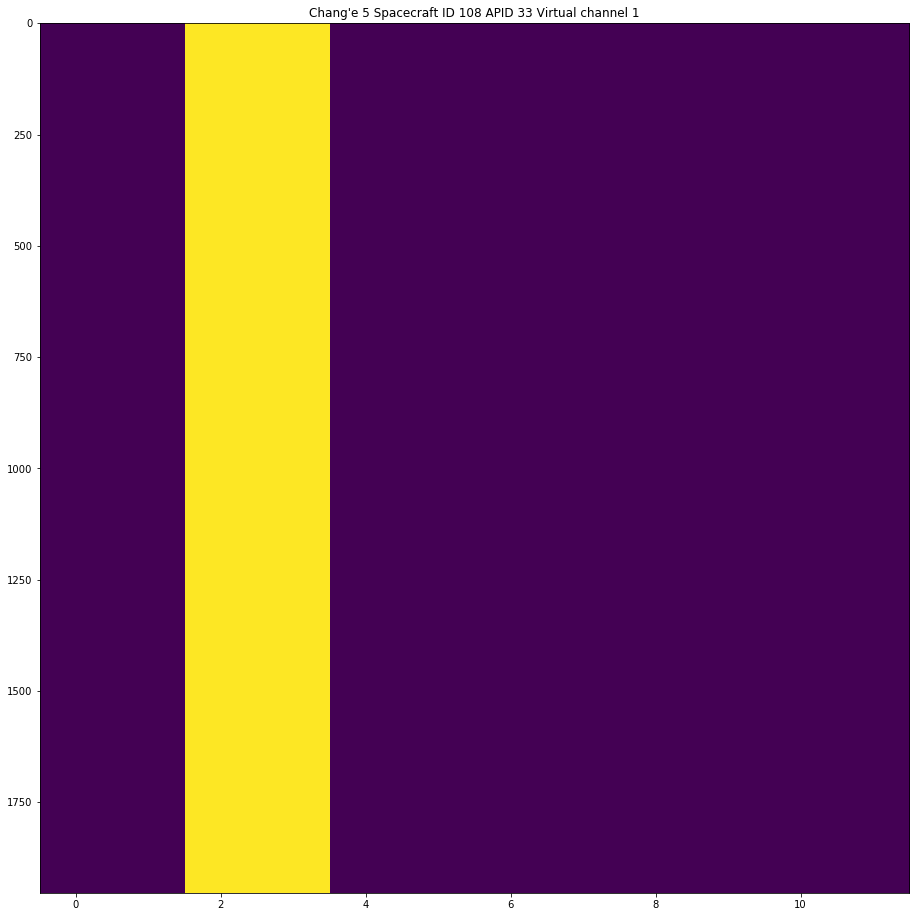

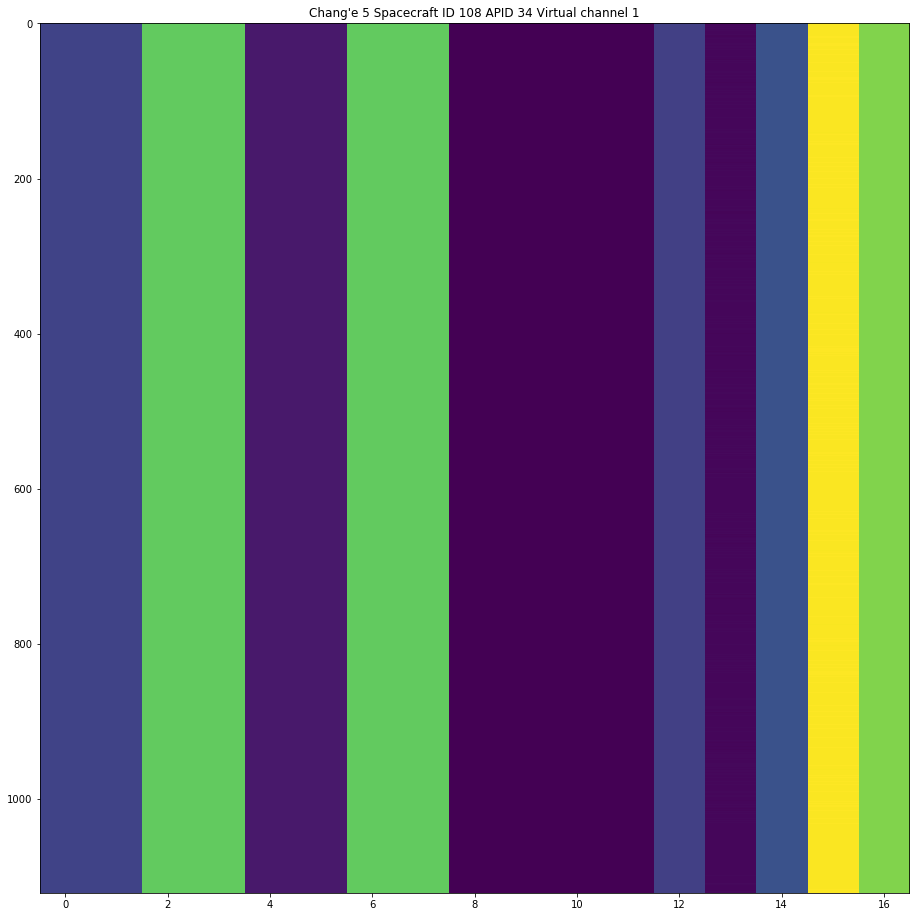

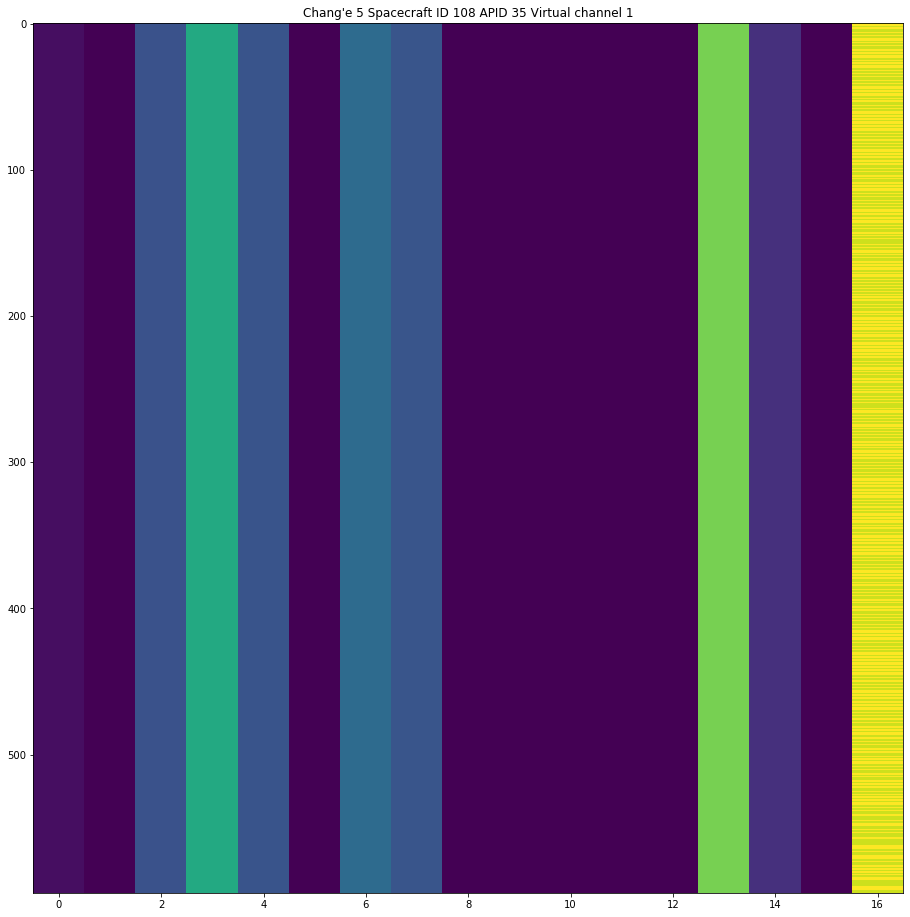

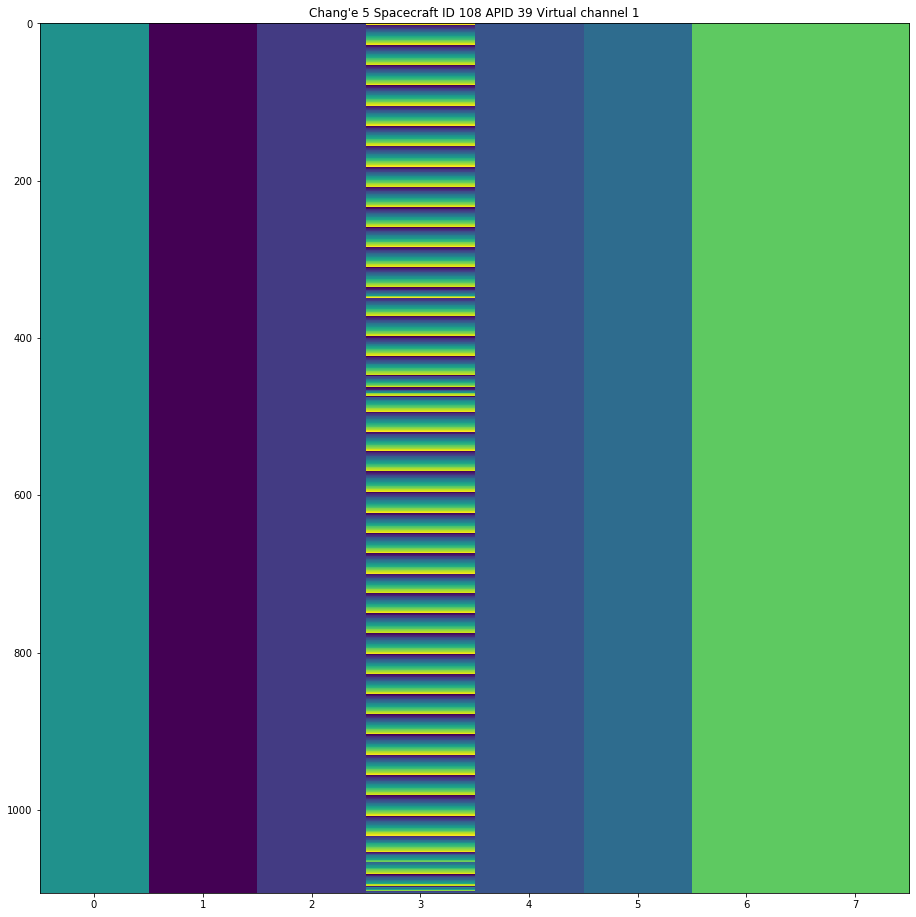

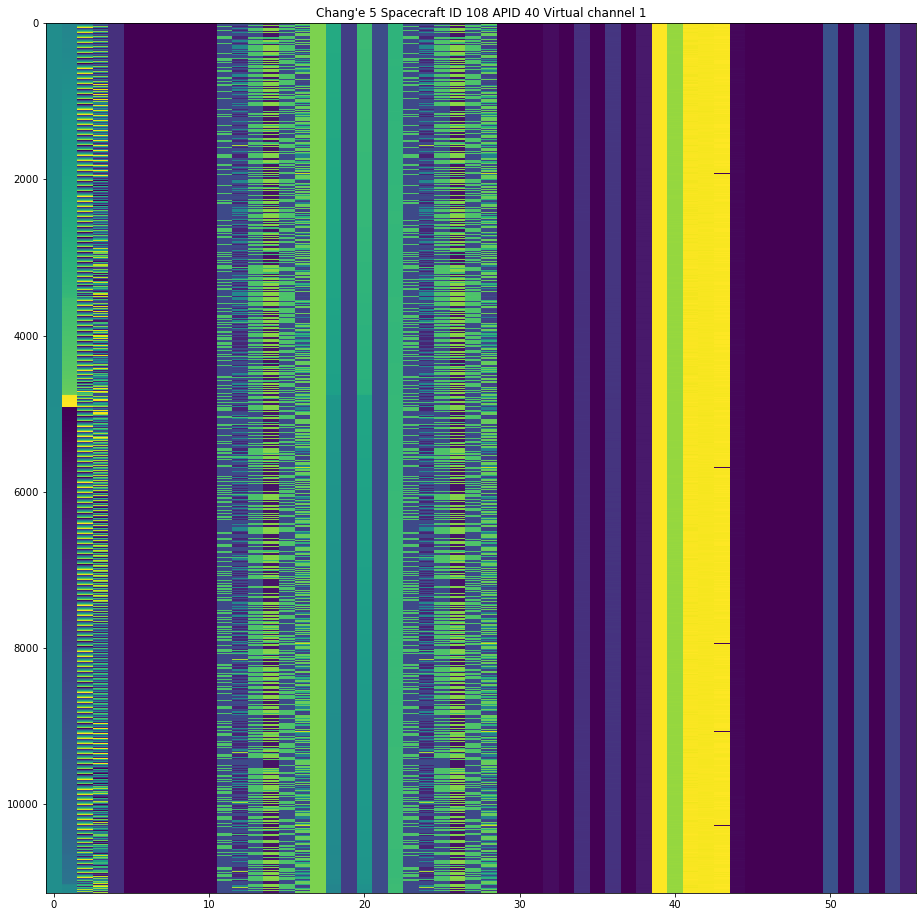

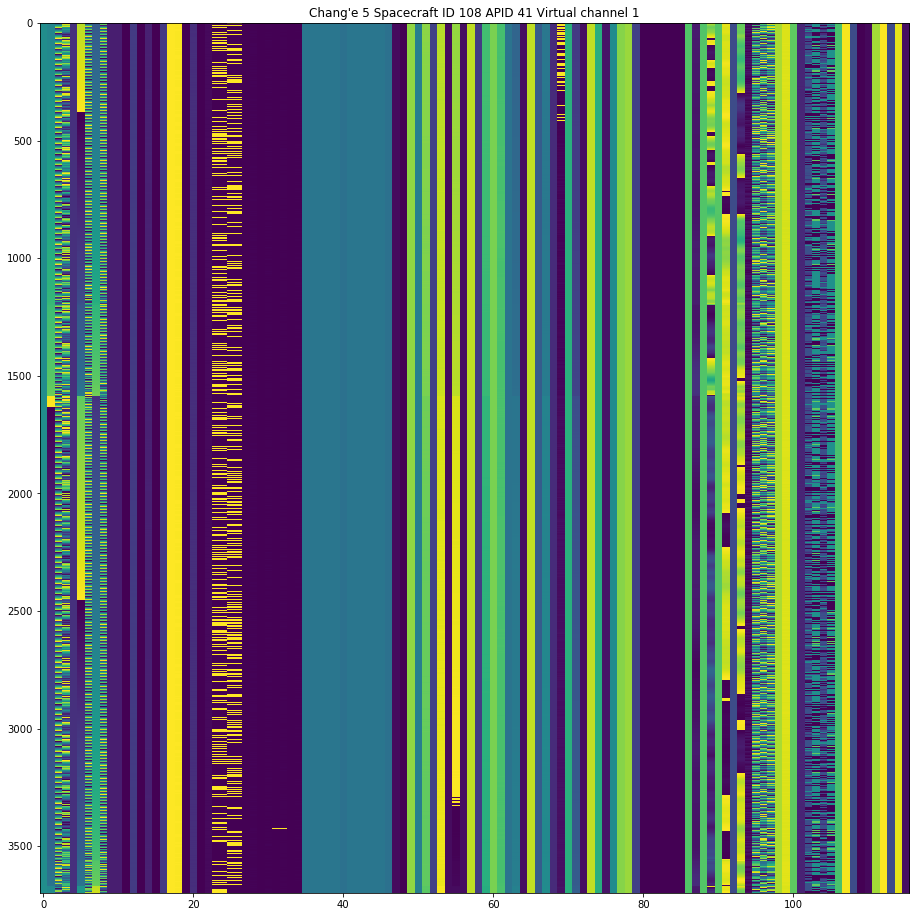

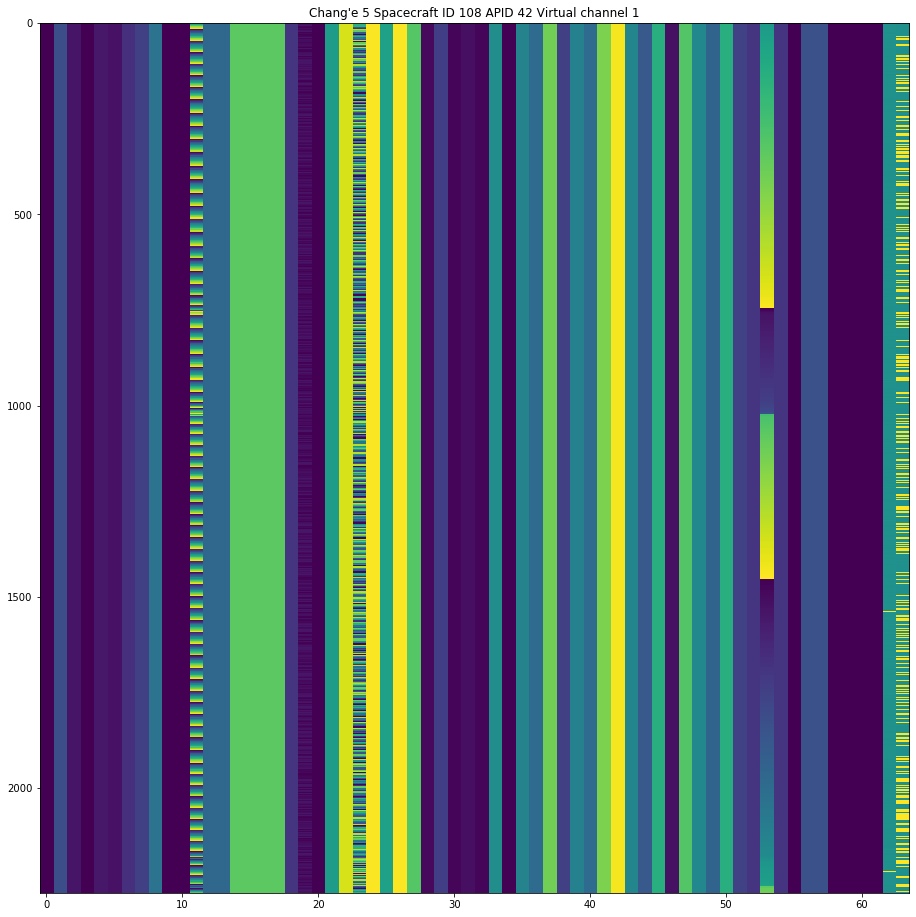

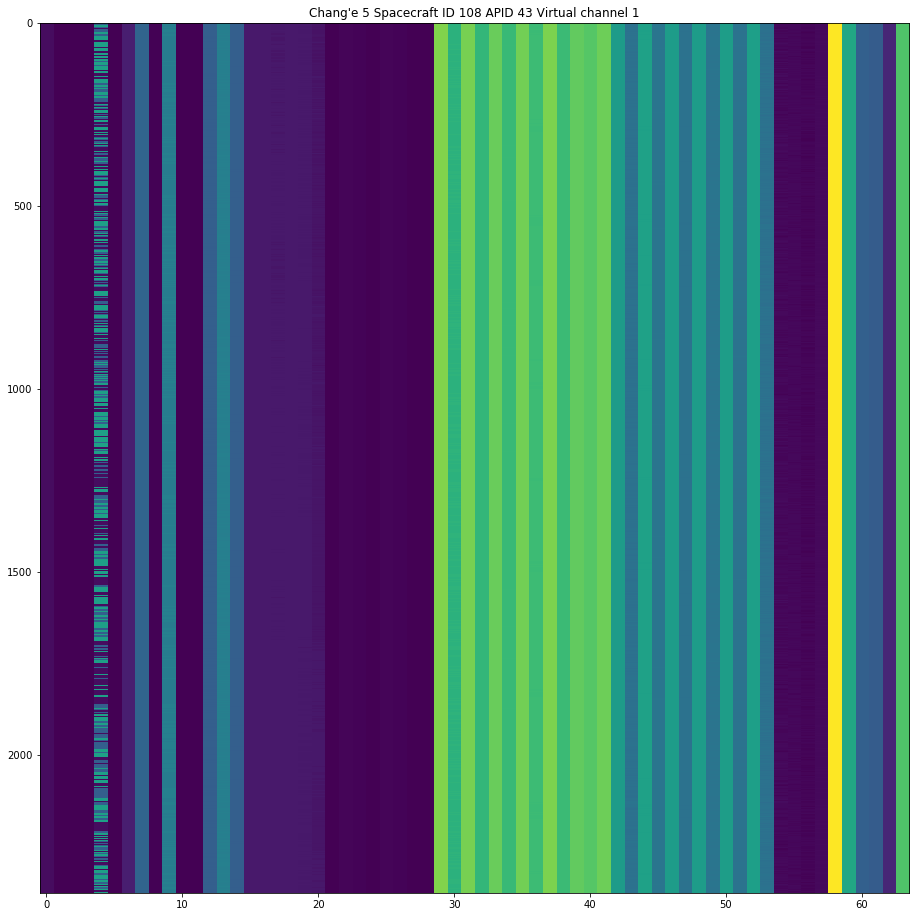

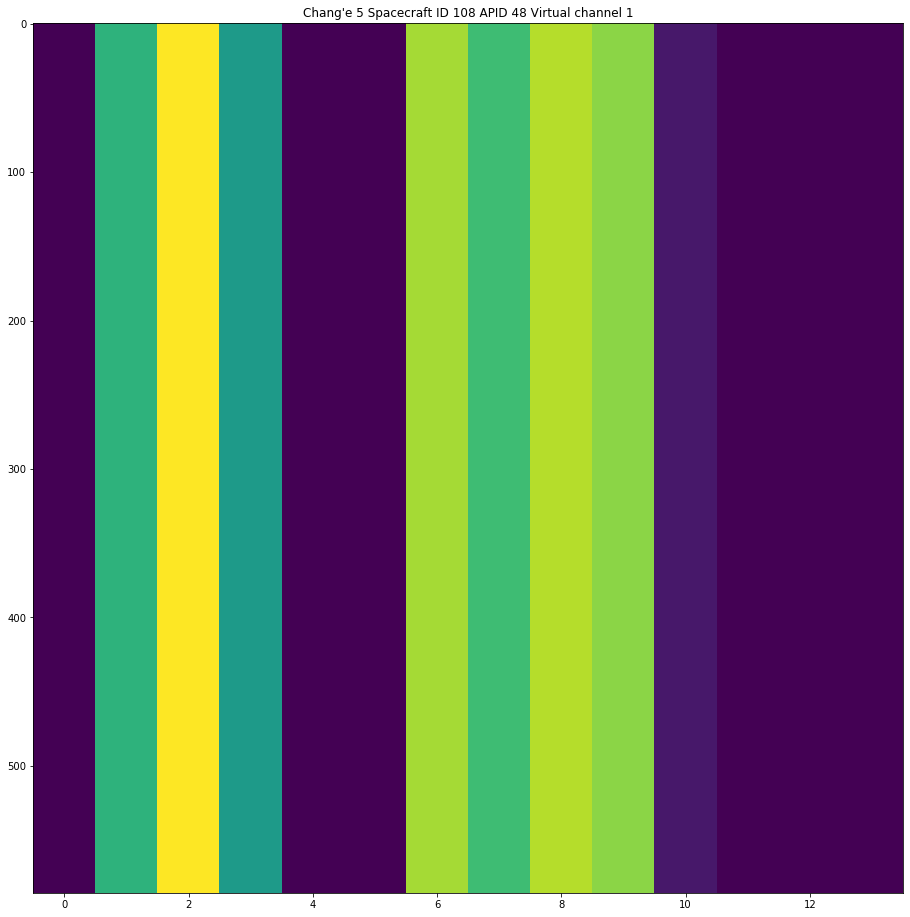

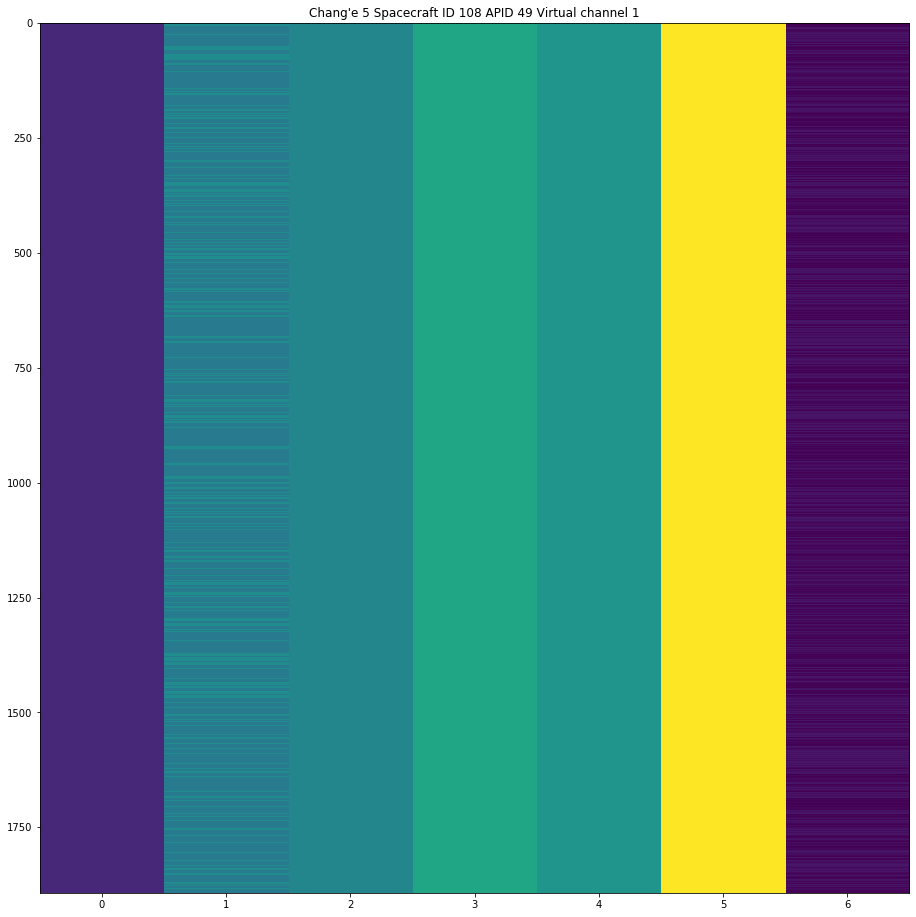

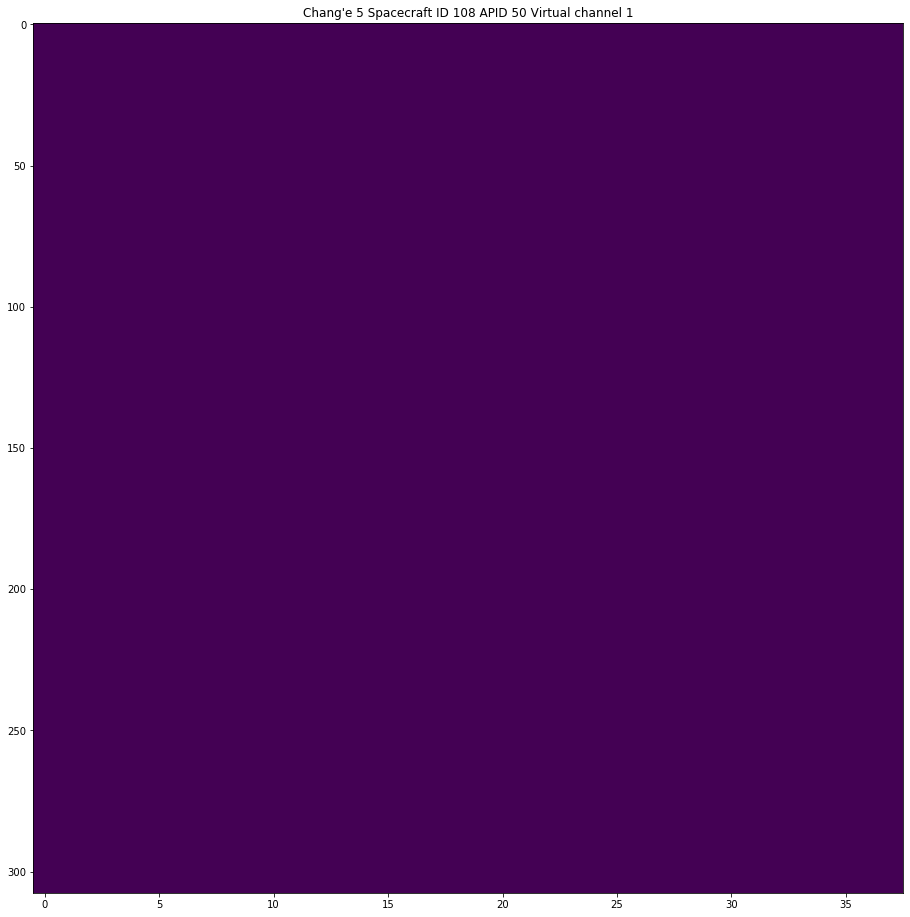

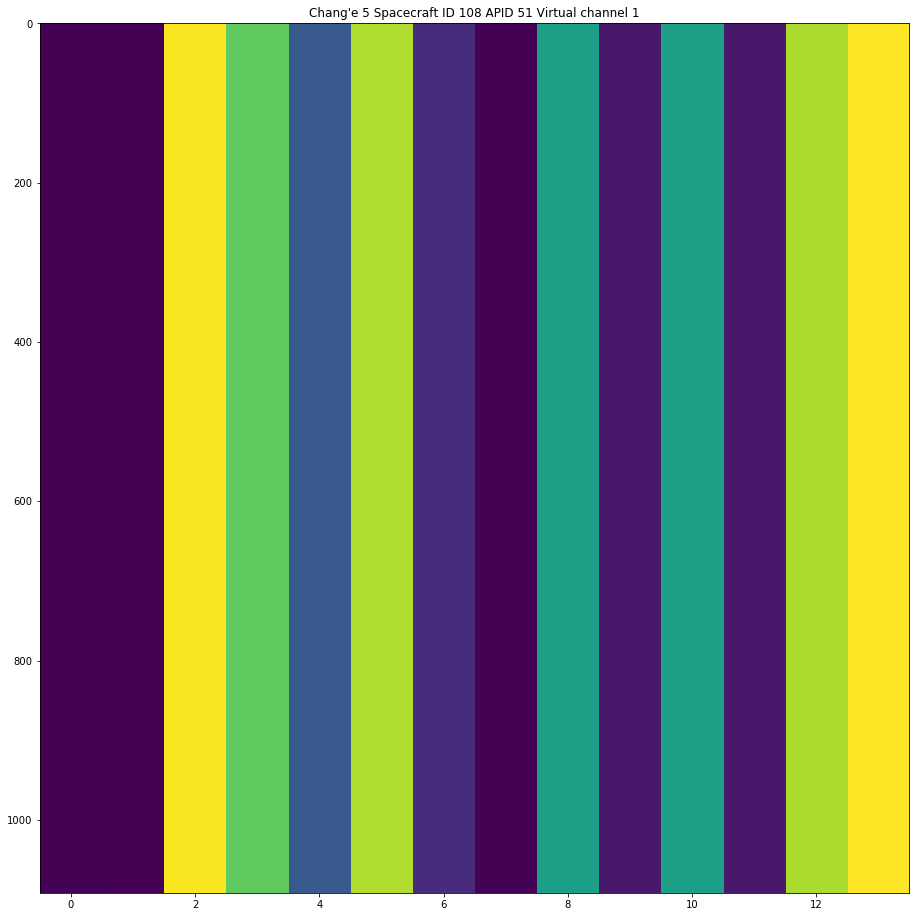

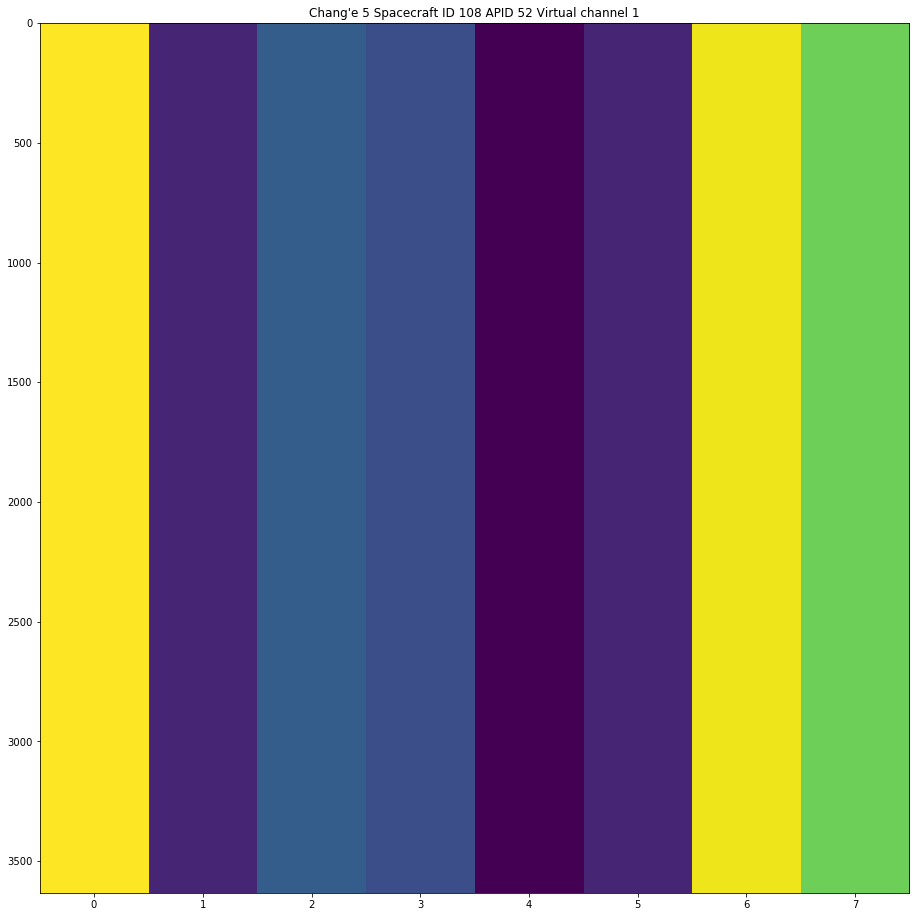

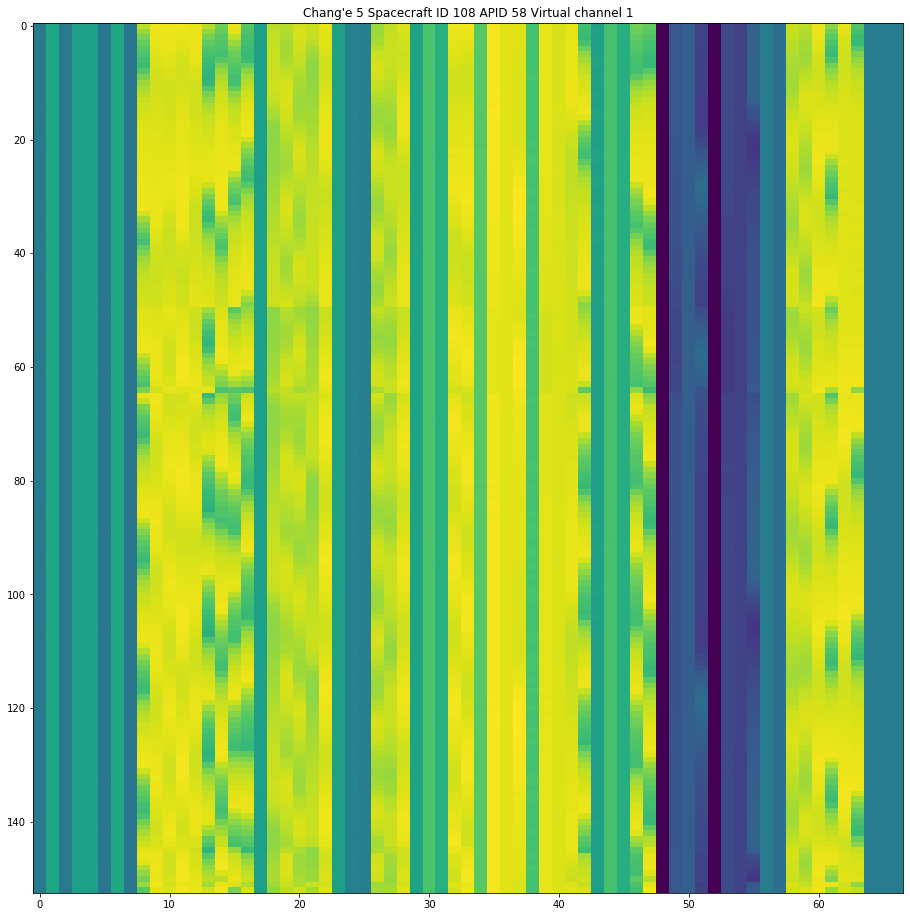

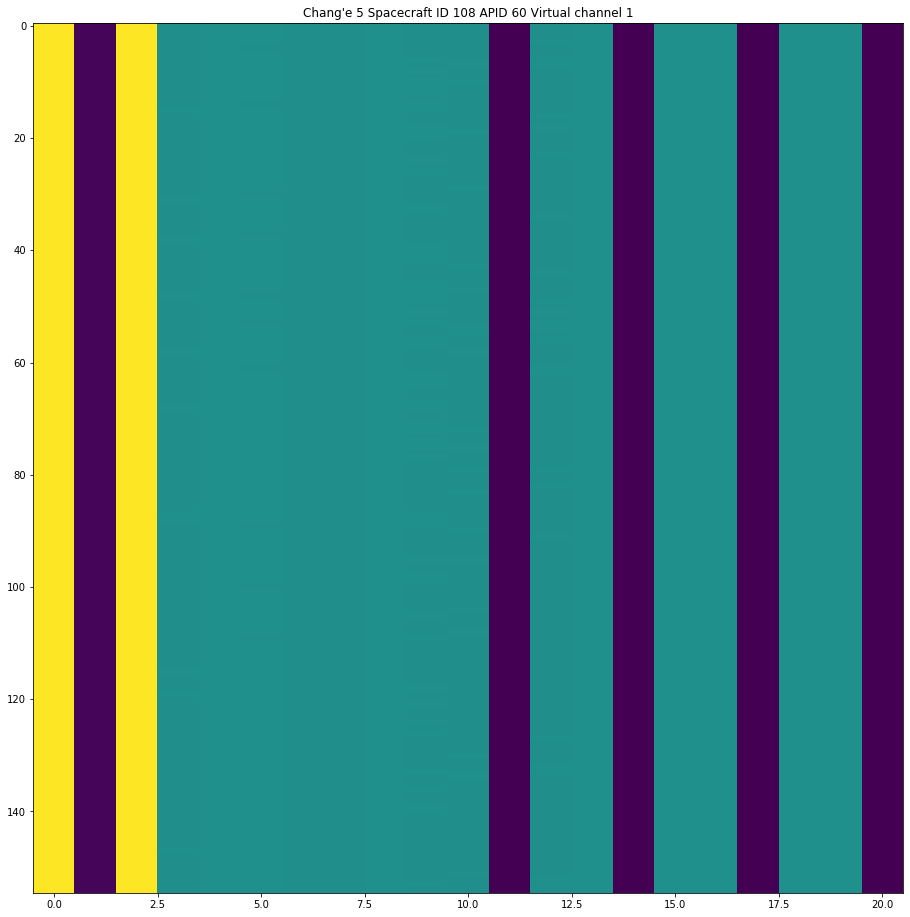

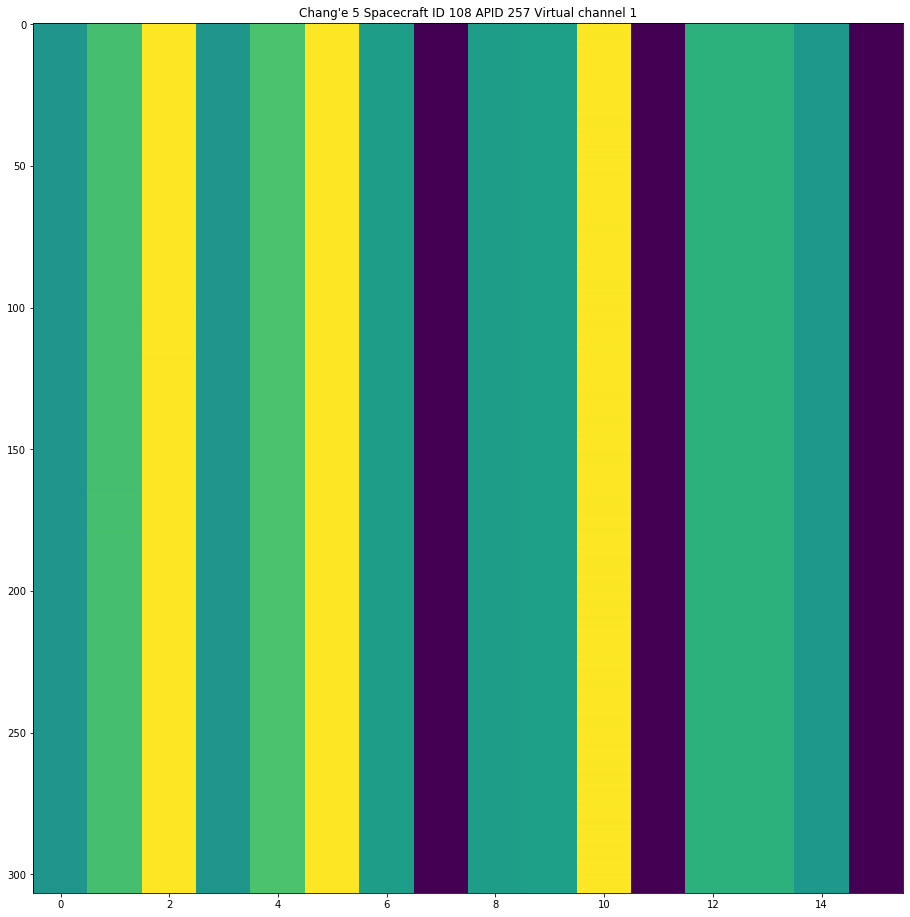

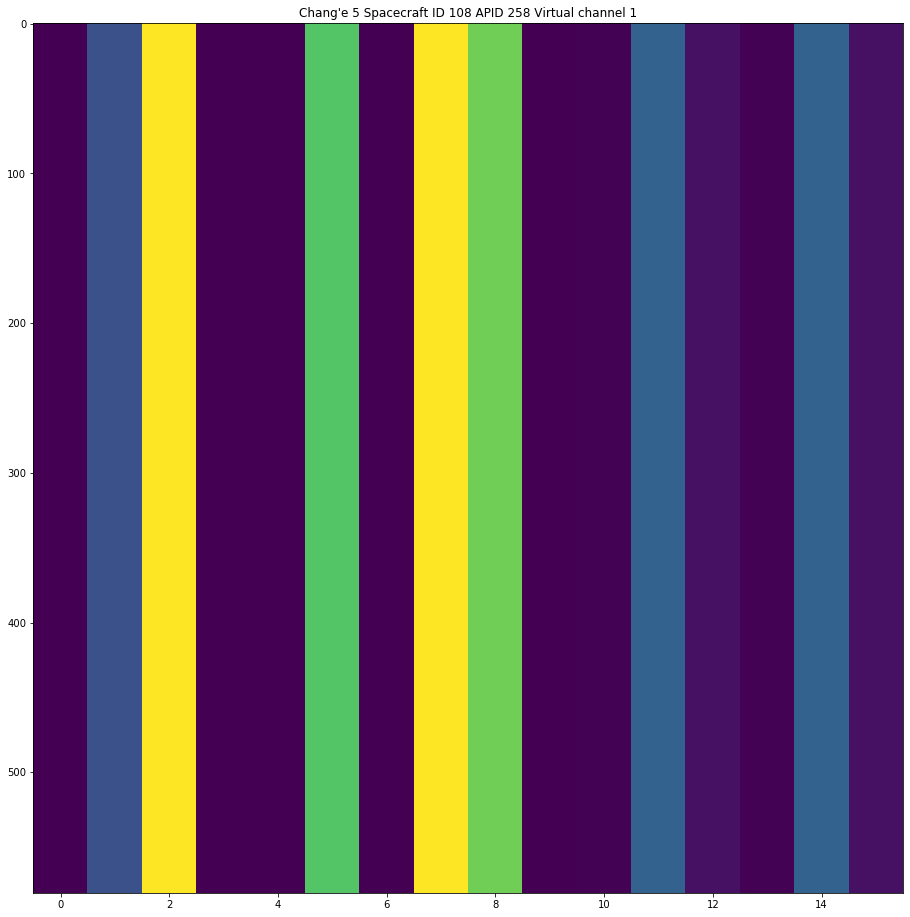

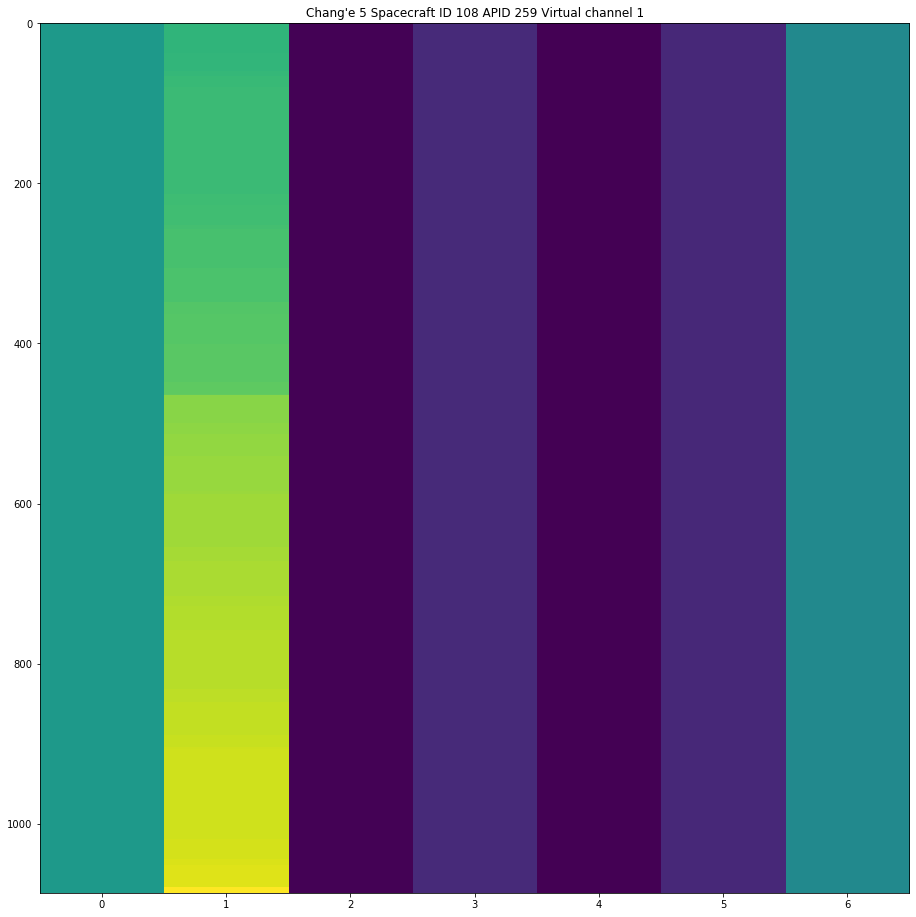

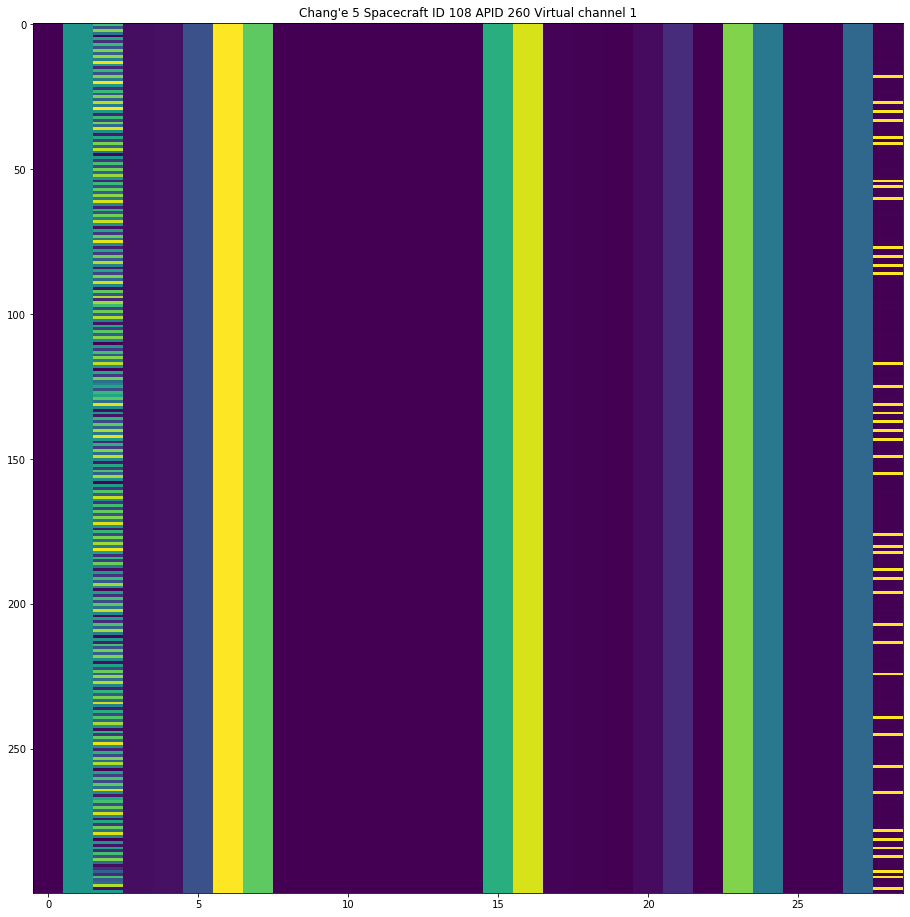

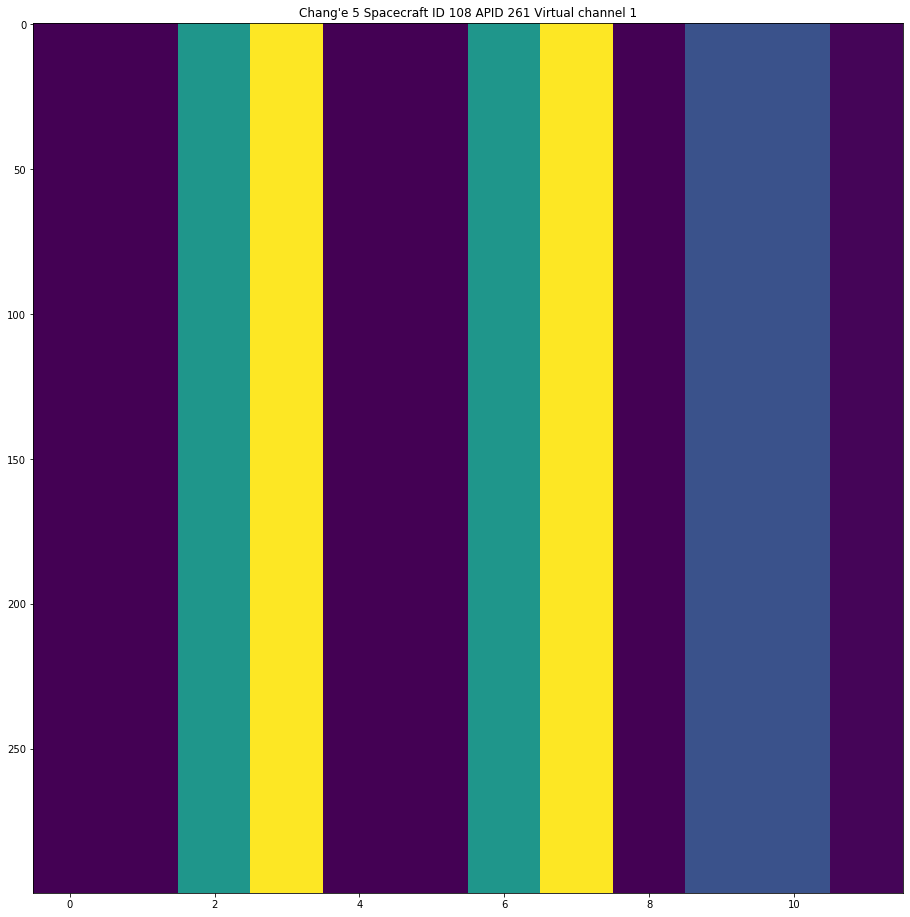

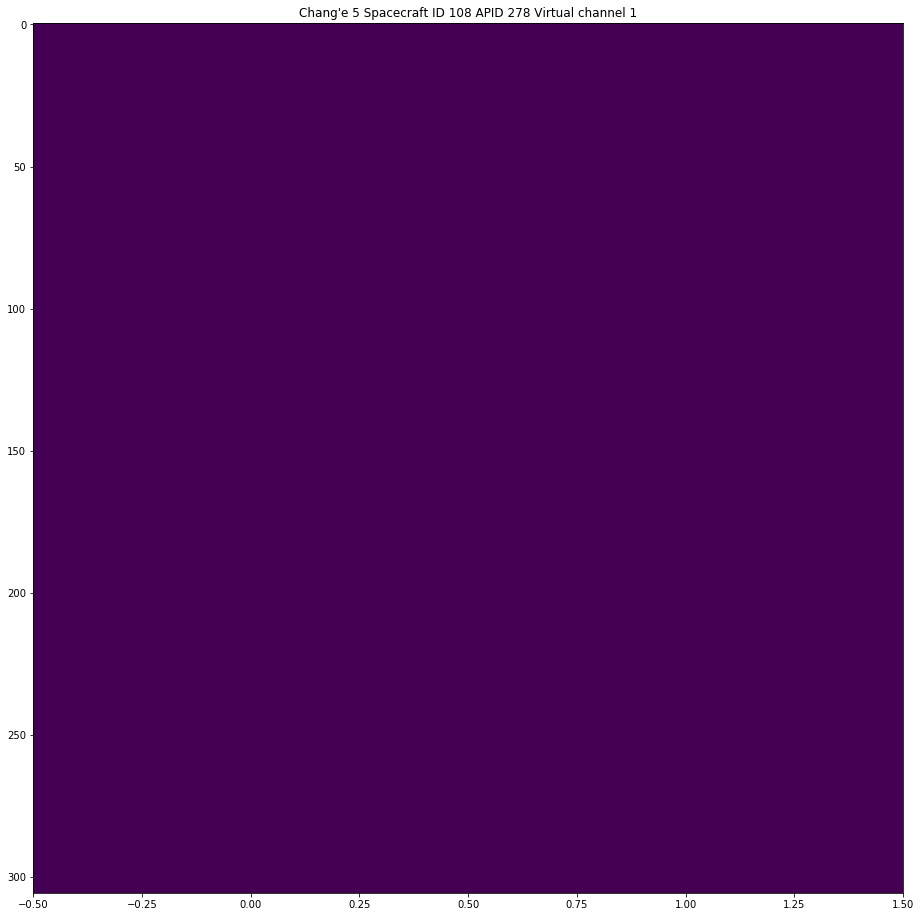

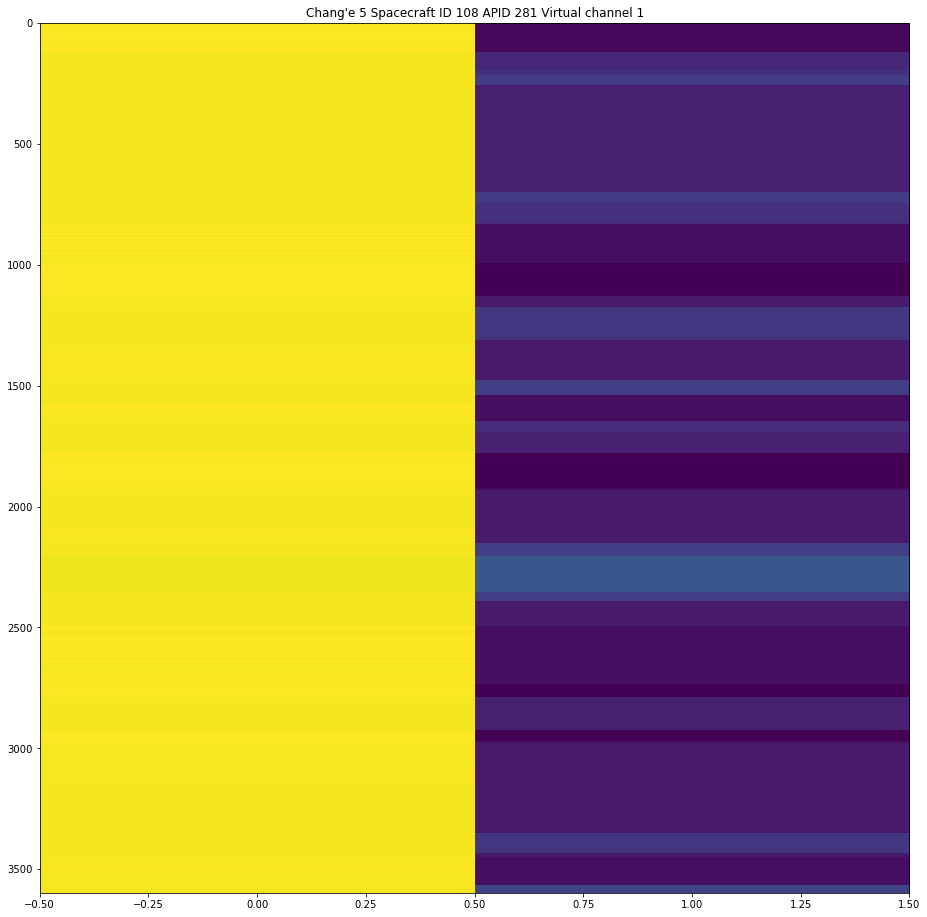

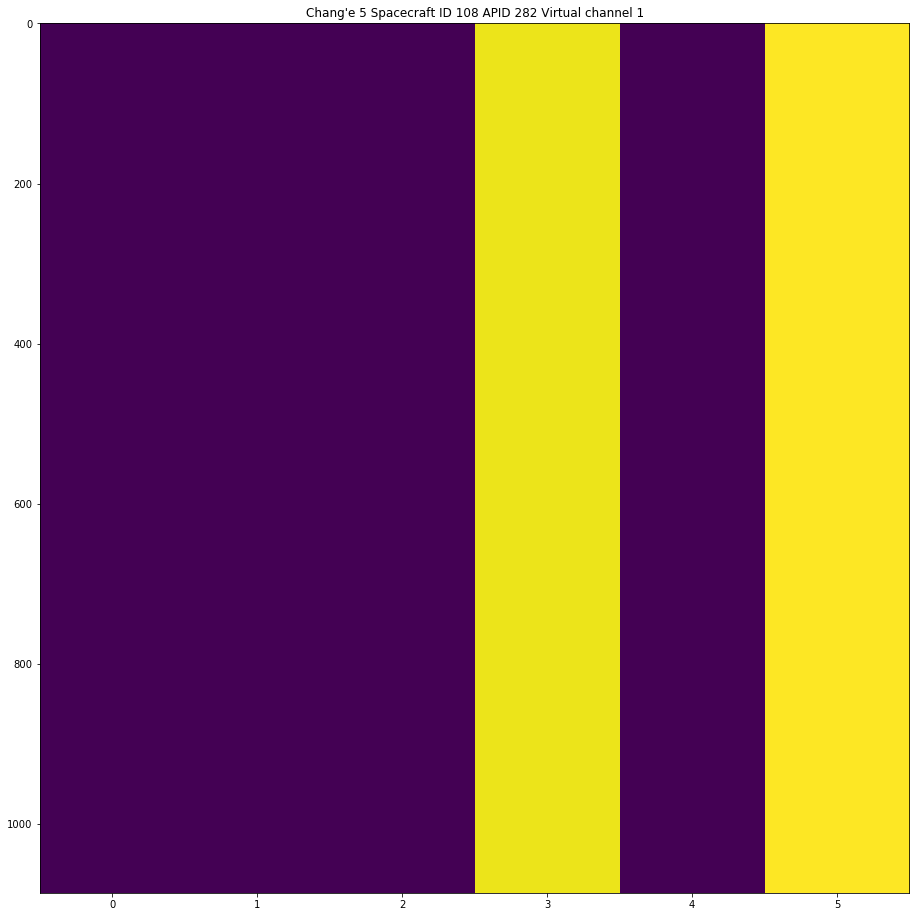

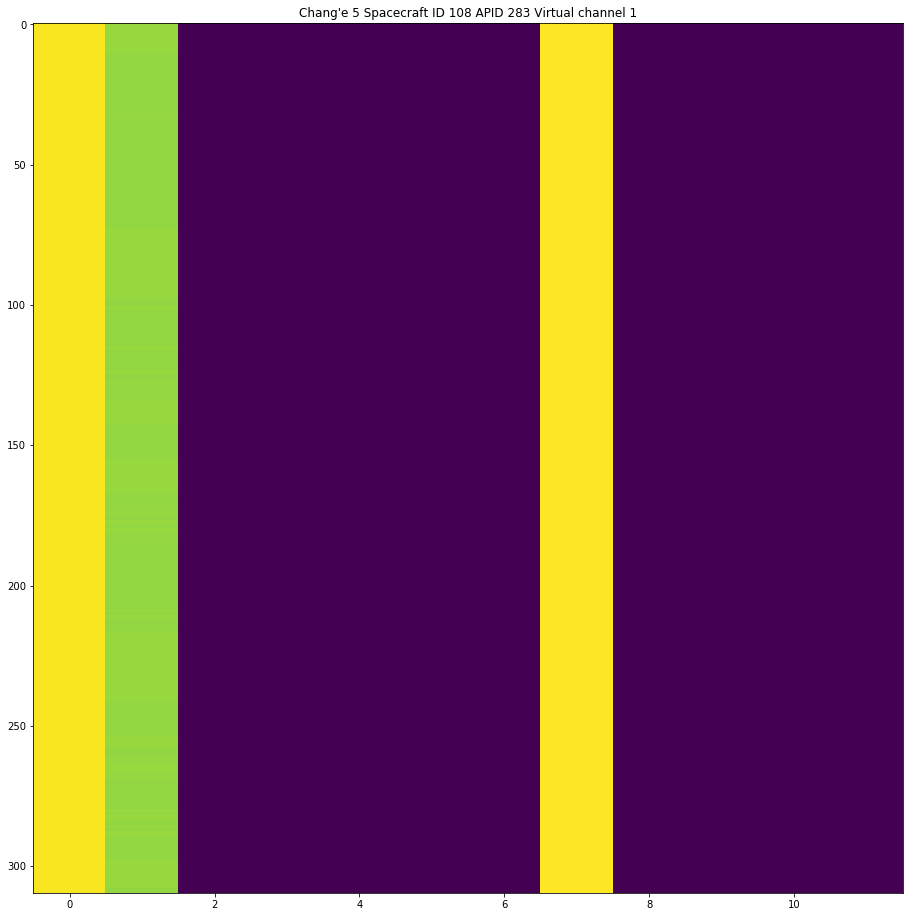

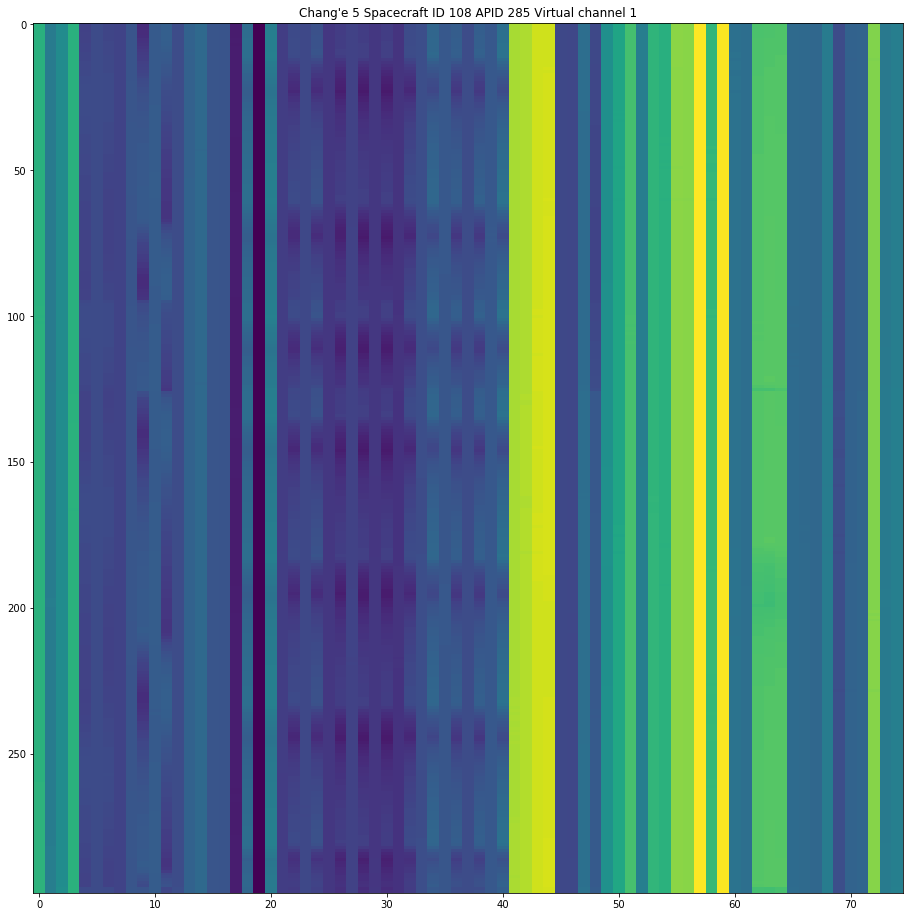

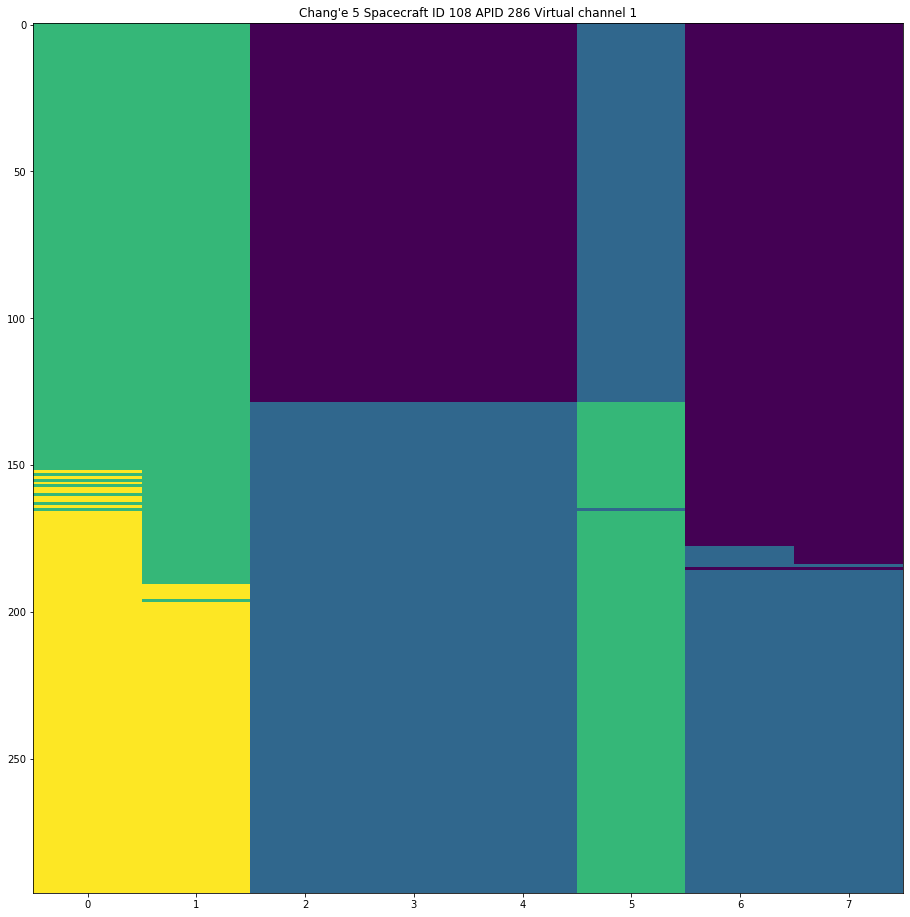

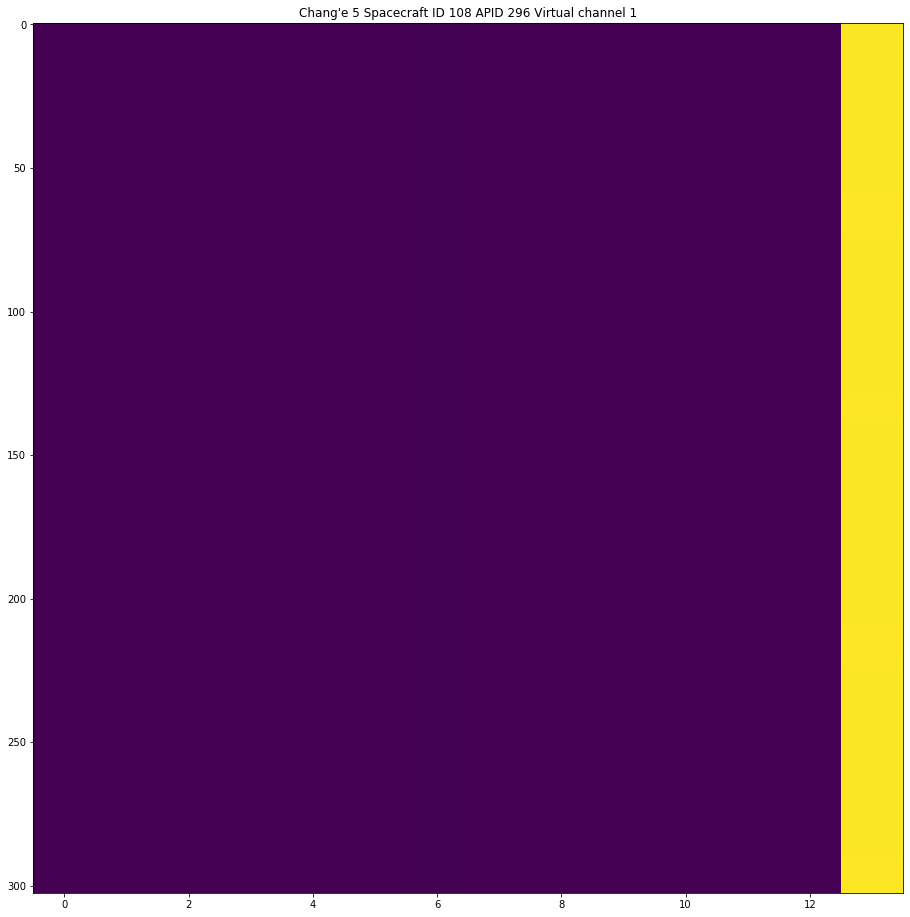

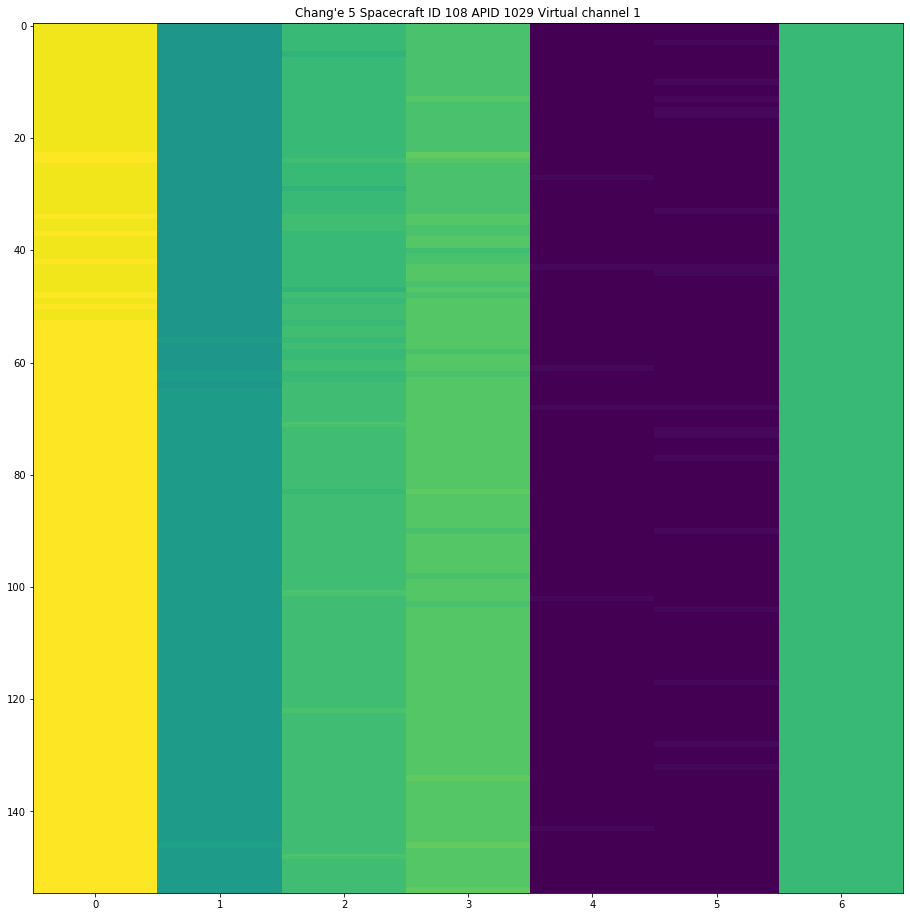

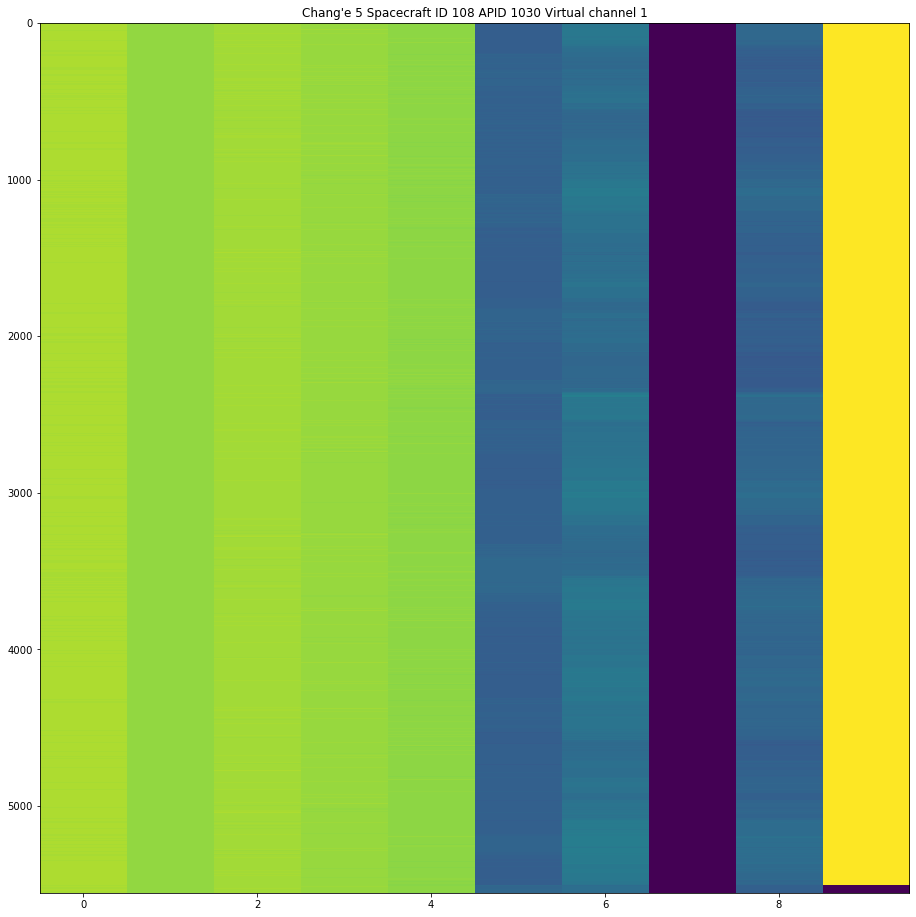

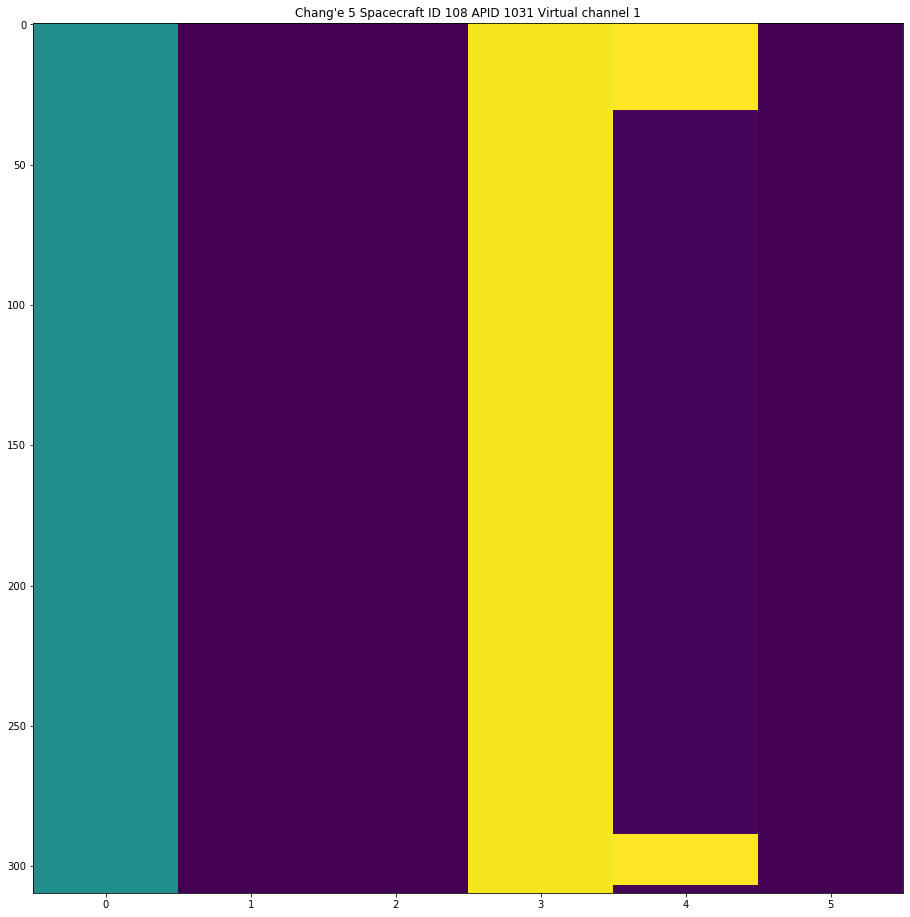

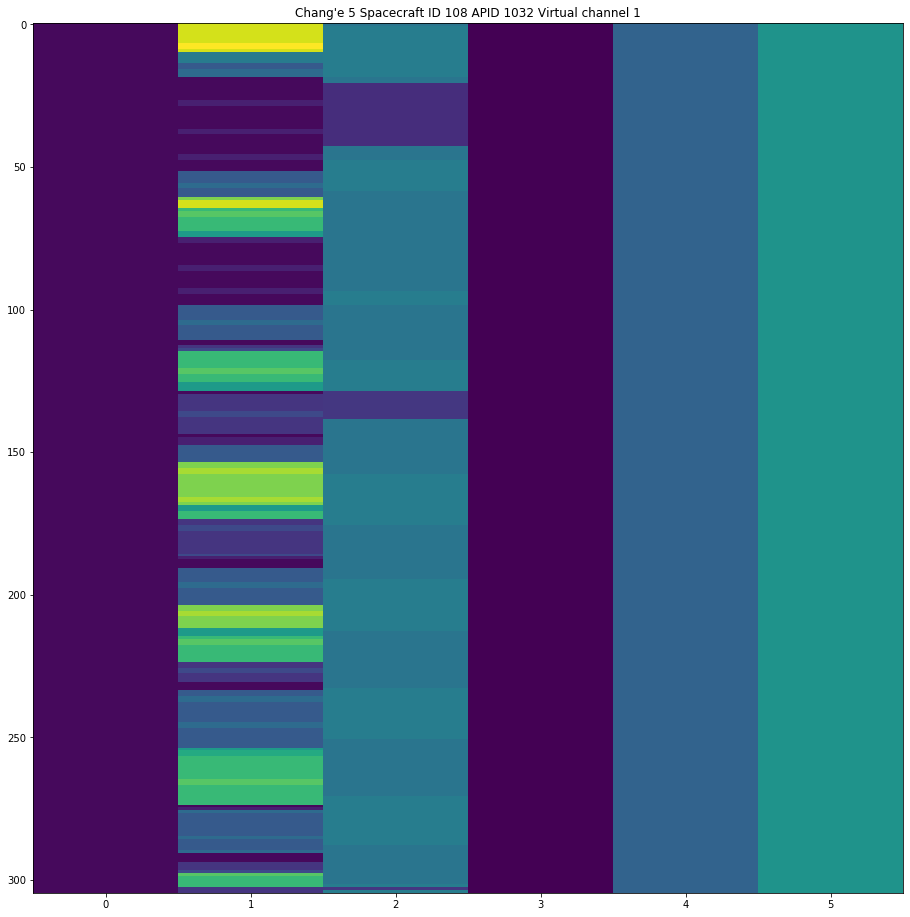

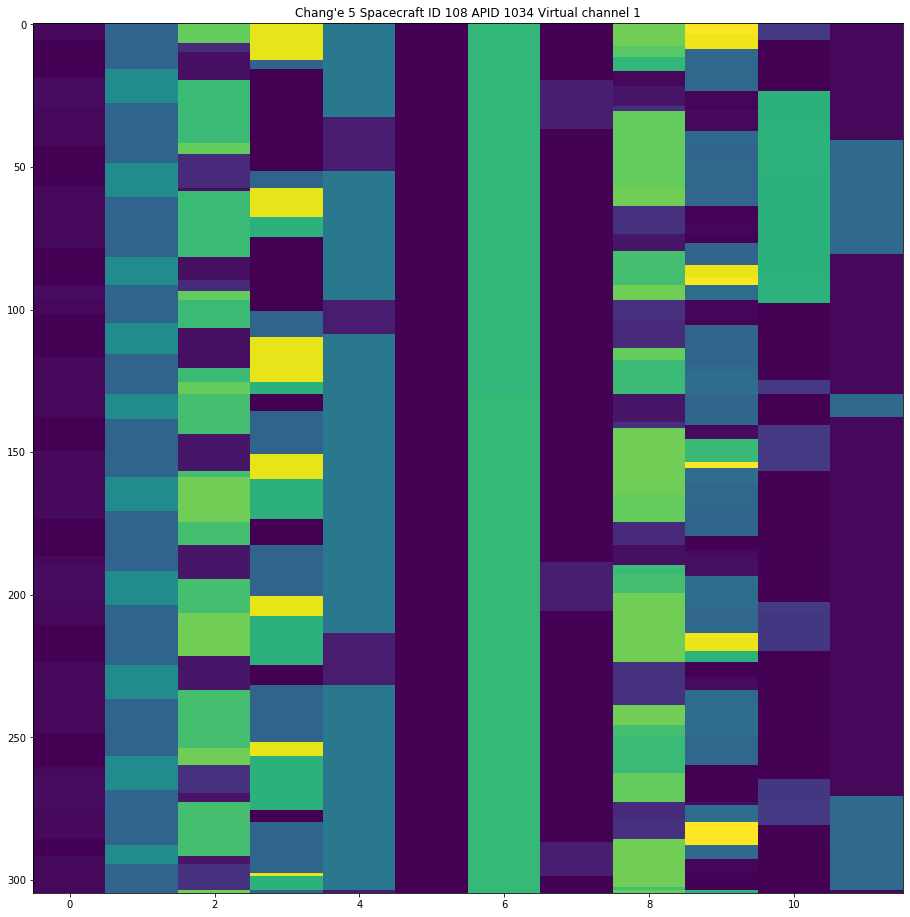

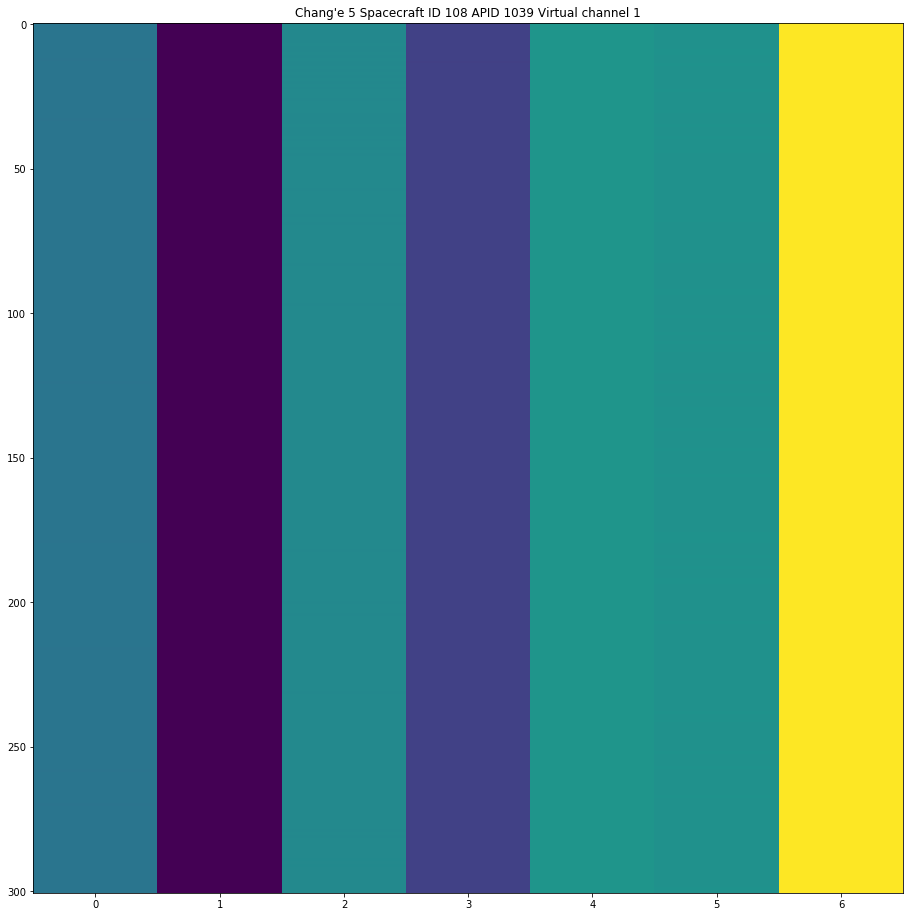

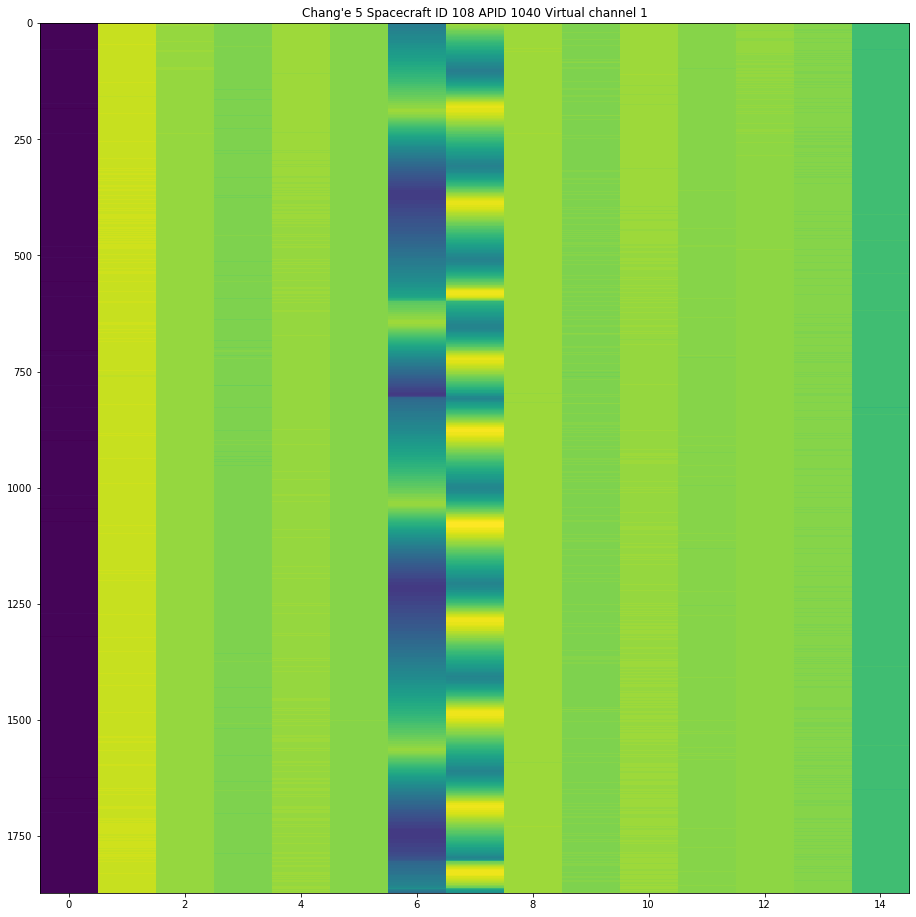

In [18]:
plot_apids(vc1_by_apid, 108, 1)